Large-Scale Data Mining: Models and Algorithms,
Niklas Zwingenberger,
02/09/2023

In [135]:
%load_ext autoreload
%autoreload 2
# Imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.cluster import contingency_matrix
from project_2.plotmat import plot_mat
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score,adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD, NMF
from matplotlib import pyplot as plt
from typing import List
from sklearn.utils.extmath import safe_sparse_dot
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from umap.umap_ import UMAP
import itertools
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import pairwise_distances
import hdbscan
import torch
import os
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import tarfile
import requests
from sklearn.manifold import TSNE
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from torch.utils.data.dataset import random_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# Basic Config
seed = 42

In [147]:
class_0_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_1_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='train', categories=class_0_categories + class_1_categories, shuffle=True,
                             random_state=seed, remove=('headers', 'footers'))
#dataset.data[0]

# Question 1

In [148]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
train_tf_idf = vectorizer.fit_transform(dataset.data)
names = vectorizer.get_feature_names_out()
print(f'Shape of train TF-IDF matrix: {train_tf_idf.shape}')

Shape of train TF-IDF matrix: (4732, 17131)


# Question 2

In [149]:
clustering = KMeans(n_clusters=2, max_iter=2000, n_init=50, random_state=0).fit(train_tf_idf)

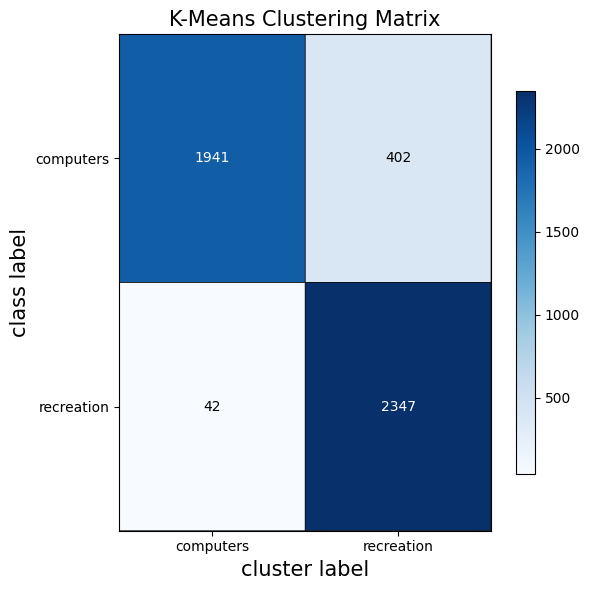

In [150]:
cluster_labels = clustering.labels_
class_names = ['computers', 'recreation']  # classes 0 and 1 respectively
class_0_label_nos = list(range(len(class_0_categories)))
class_1_label_nos = list(range(len(class_0_categories), len(class_1_categories) + len(class_1_categories)))
class_labels = np.array([0 if t in class_0_label_nos else 1 for t in dataset.target])
cont_matrix = contingency_matrix(class_labels, cluster_labels)

# Plot matrix
plot_mat(cont_matrix, size=(6, 6), ylabel='class label', xlabel='cluster label', title='K-Means Clustering Matrix',
         xticklabels=class_names, yticklabels=class_names)

## Does the contingency matrix have to be square-shaped?
No, that is not required. There are different reasons to use a differing number of clusters:

- **\# of class labels = \# of clusters**: allows checking how well a cluster can distinguish existing class labels
- **\# of class labels < \# of clusters**: allows identifying possible new class labels that an existing class label can be divided into.
- **\# of class labels > \# of clusters**: allows identifying existing class labels that could be merged, if they are often assigned to the same cluster.

Also some clustering methods such as HDBSCAN choose the number of clusters themselves, so they are not guaranteed to get the same number as there are actual classes.

# Question 3

In [151]:
def calculate_cluster_metrics(class_labels: List[int], cluster_labels: List[int]):
    # Homogeneity
    h_score = homogeneity_score(labels_true=class_labels, labels_pred=cluster_labels)
    # Completeness
    c_score = completeness_score(labels_true=class_labels, labels_pred=cluster_labels)
    # V-measure
    v_score = v_measure_score(labels_true=class_labels, labels_pred=cluster_labels)
    # Adjusted Rand Index
    ar_score = adjusted_rand_score(labels_true=class_labels, labels_pred=cluster_labels)
    # Adjusted mutual information score
    am_score = adjusted_mutual_info_score(labels_true=class_labels, labels_pred=cluster_labels)

    return h_score, c_score, v_score, ar_score, am_score


def print_cluster_metrics(h_score: float, c_score: float, v_score: float, ar_score: float, am_score: float):
    print(f'Homogeneity Score: {h_score:.3f}')
    print(f'Completeness Score: {c_score:.3f}')
    print(f'V-Measure Score: {v_score:.3f}')
    print(f'Adjusted Rand Index: {ar_score:.3f}')
    print(f'Adjusted Mutual Information Score: {am_score:.3f}')
    print(f'Mean score {np.mean([h_score, c_score, v_score, ar_score, am_score]):.3f}')

print_cluster_metrics(*calculate_cluster_metrics(class_labels, cluster_labels))

Homogeneity Score: 0.589
Completeness Score: 0.601
V-Measure Score: 0.595
Adjusted Rand Index: 0.660
Adjusted Mutual Information Score: 0.595
Mean score 0.608


# Question 4

In [156]:
# Latent Semantic Indexing
def reduce_dim_lsi(k: int, data):
    lsi = TruncatedSVD(n_components=k, random_state=seed)
    reduced_train_data = lsi.fit_transform(data)
    return lsi, reduced_train_data


variance_ratios = []
cumulative_variance_ratios = []
ranges = [1, 10, 50, 100, 200, 500, 1000]
l, _ = reduce_dim_lsi(1000, train_tf_idf)
cumulative_explained_variance_ratio = np.cumsum(l.explained_variance_ratio_)
for r in ranges:
    variance_ratios.append(l.explained_variance_ratio_[:r])
    cumulative_variance_ratios.append(cumulative_explained_variance_ratio[:r])

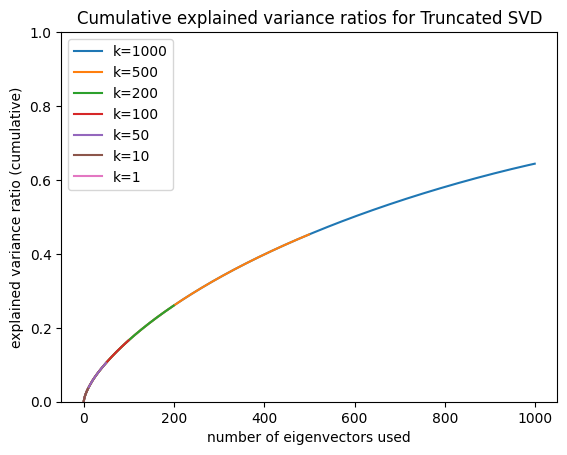

In [157]:
# Plot cumulative variance ratios
for r in reversed(cumulative_variance_ratios):
    k = len(r)
    plt.plot(r, label=f'k={k}')
plt.legend()
plt.xlabel('number of eigenvectors used')
plt.ylabel('explained variance ratio (cumulative)')
plt.title('Cumulative explained variance ratios for Truncated SVD')
plt.ylim([0,1])

plt.show()

# Question 5

In [158]:
# Non-negative Matrix Factorization
def reduce_dim_nmf(k: int, data):
    nmf = NMF(n_components=k, init='random', random_state=seed, max_iter=1000)
    reduced_train_data = nmf.fit_transform(data)  # performing NMF on the tfidf train matrix
    return nmf, reduced_train_data

In [159]:
# Explore component ranges
ranges = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
svd_scores = []
nmf_scores = []

for r in tqdm(ranges):
    # Doing the SVD calculation manually instead of transform() so we can slice the number of components
    svd_representation = safe_sparse_dot(train_tf_idf, l.components_[:r].T)
    _, nmf_representation = reduce_dim_nmf(r, train_tf_idf)

    for rep, scores in zip([svd_representation, nmf_representation], [svd_scores, nmf_scores]):
        clustering = KMeans(n_clusters=2, max_iter=2000, n_init=50, random_state=0).fit(rep)
        cluster_labels = clustering.labels_
        scores.append(calculate_cluster_metrics(class_labels, cluster_labels))

100%|██████████| 14/14 [09:34<00:00, 41.06s/it] 


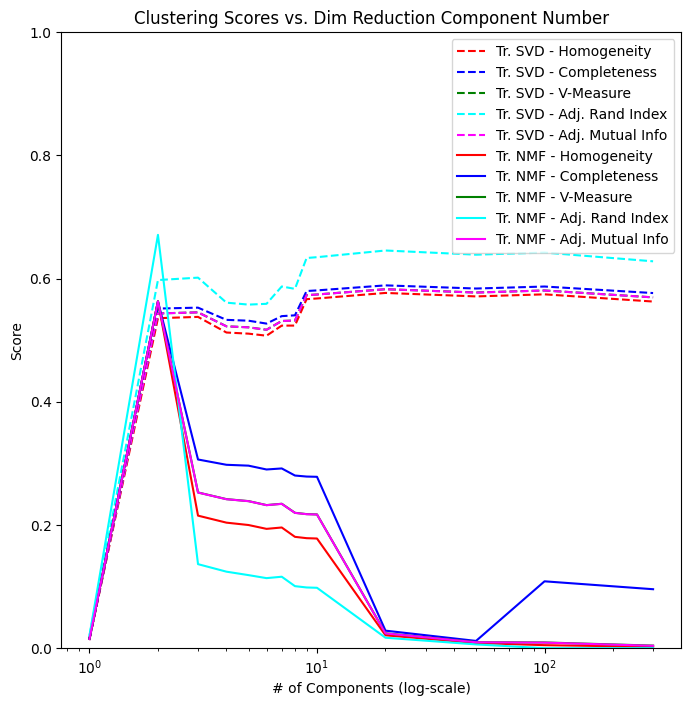

In [160]:
# Plot scores
plt.figure(figsize=(8, 8))
plot_labels = ['Homogeneity', 'Completeness', 'V-Measure', 'Adj. Rand Index', 'Adj. Mutual Info']
colors = ['red', 'blue','green','cyan', 'magenta']
svd_scores_np = np.array(svd_scores)
nmf_scores_np = np.array(nmf_scores)
for j in range(svd_scores_np.shape[1]):
    plt.plot(ranges,svd_scores_np[:,j],'--', label=f'Tr. SVD - {plot_labels[j]}', color=colors[j])

for j in range(nmf_scores_np.shape[1]):
    plt.plot(ranges,nmf_scores_np[:,j],'-', label=f'Tr. NMF - {plot_labels[j]}', color=colors[j])

plt.ylim([0,1])
plt.title('Clustering Scores vs. Dim Reduction Component Number')
plt.ylabel('Score')
plt.xscale('log')
plt.xlabel('# of Components (log-scale)')
plt.legend()
plt.show()

In [161]:
mean_svd_scores = svd_scores_np.mean(axis=1)
best_svd_scores_idx = np.argmax(mean_svd_scores)
print(f'\nBest SVD Scores r={ranges[best_svd_scores_idx]}:')
print_cluster_metrics(*svd_scores_np[best_svd_scores_idx,:])

mean_nmf_scores = nmf_scores_np.mean(axis=1)
best_nmf_scores_idx = np.argmax(mean_nmf_scores)
print(f'\nBest NMF Scores r={ranges[best_nmf_scores_idx]}:')
print_cluster_metrics(*nmf_scores_np[best_nmf_scores_idx,:])


Best SVD Scores r=20:
Homogeneity Score: 0.577
Completeness Score: 0.589
V-Measure Score: 0.583
Adjusted Rand Index: 0.645
Adjusted Mutual Information Score: 0.583
Mean score 0.595

Best NMF Scores r=2:
Homogeneity Score: 0.563
Completeness Score: 0.563
V-Measure Score: 0.563
Adjusted Rand Index: 0.671
Adjusted Mutual Information Score: 0.563
Mean score 0.584


# Question 6
## How do you explain the non-monotonic behavior of the measures as $r$ increases?
In theory, the K-Means should struggle when using the Euclidean distance with high-dimensional data as the distances between points become too homogeneous, making it difficult to form dense clusters. In practice it seems that the choice of dimensionality reduction method has a significant effect. SVD only somewhat degrades when the number of dimensions increases, whereas NMF sharply declines past ~5 components.

# Question 7
## Are these measures on average better than those computed in Question 3?
The measures are about the same if not slightly worse than TF-IDF (~0.6), which is unexpected. It seems that even though the raw TF-IDF has ~17k dimensions it really isn't doing that badly. This interesting, as the representations generated by SVD and NMF are actually quite different and more varied than TF-IDF (see histograms showing pair-wise distances below). Therefore, it should be more difficult for K-Means to form good clusters. However, if we look a bit further at the visualisations in Q8 it becomes apparent that regardless of representation, the Euclidean distance metric is unable to meaningfully separate the clusters.

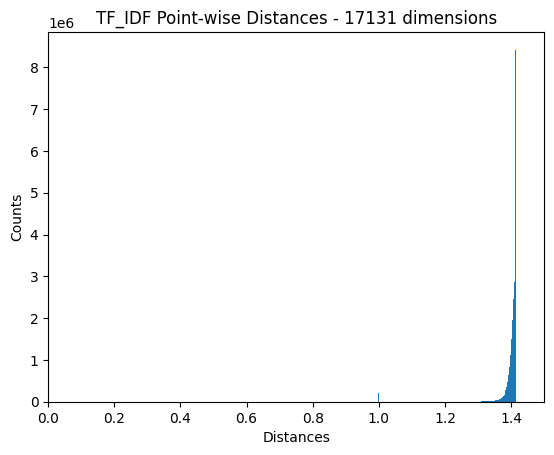

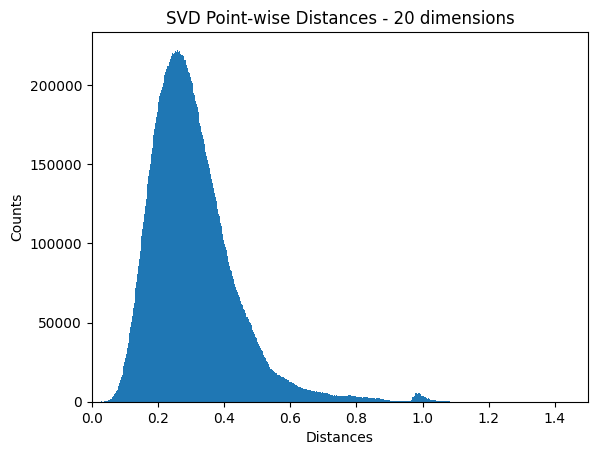

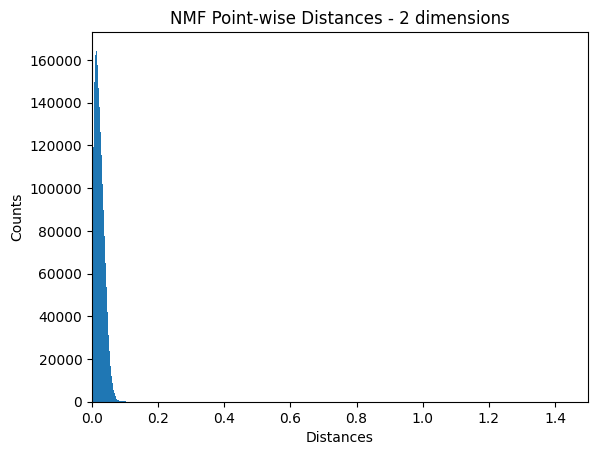

In [162]:
_, best_nmf_representation = reduce_dim_nmf(ranges[best_nmf_scores_idx], train_tf_idf)
_, best_svd_representation = reduce_dim_lsi(ranges[best_svd_scores_idx], train_tf_idf)
def plot_distance_histogram(data_representation: np.ndarray, title:str):
    d = pairwise_distances(data_representation, data_representation)
    plt.hist(d.flatten(),bins=500)
    plt.title(title)
    plt.ylabel('Counts')
    plt.xlabel('Distances')
    plt.xlim([0,1.5])
    plt.show()

plot_distance_histogram(train_tf_idf, f'TF_IDF Point-wise Distances - {train_tf_idf.shape[1]} dimensions')
plot_distance_histogram(best_svd_representation, f'SVD Point-wise Distances - {ranges[best_svd_scores_idx]} dimensions')
plot_distance_histogram(best_nmf_representation, f'NMF Point-wise Distances - {ranges[best_nmf_scores_idx]} dimensions')

# Question 8

In [163]:
# Project base data down using SVD
projected_base_svd_data = TruncatedSVD(n_components=2, random_state=seed).fit_transform(train_tf_idf)

# Project optimal data down twice with SVD
optimal_svd_reduced_data = TruncatedSVD(n_components=ranges[best_svd_scores_idx], random_state=seed).fit_transform(train_tf_idf)
optimal_svd_labels = KMeans(n_clusters=2, max_iter=2000, n_init=50, random_state=0).fit_predict(optimal_svd_reduced_data)
projected_optimal_svd_data = TruncatedSVD(n_components=2, random_state=seed).fit_transform(optimal_svd_reduced_data)

# Project base data down using NMF
projected_base_nmf_data = NMF(n_components=2, random_state=seed).fit_transform(train_tf_idf)

# Project optimal data down twice with NMF
optimal_nmf_reduced_data = NMF(n_components=ranges[best_nmf_scores_idx], random_state=seed).fit_transform(train_tf_idf)
optimal_nmf_labels = KMeans(n_clusters=2, max_iter=2000, n_init=50, random_state=0).fit_predict(optimal_nmf_reduced_data)
projected_optimal_nmf_data = NMF(n_components=2, random_state=seed).fit_transform(optimal_nmf_reduced_data)

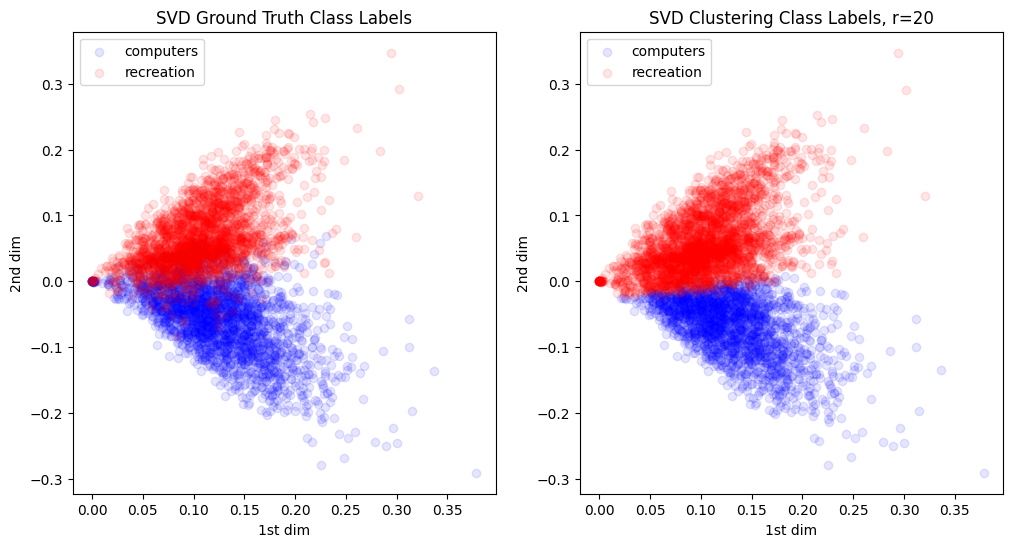

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

class_0_indices = np.where(class_labels == 0)[0]
class_1_indices = np.where(class_labels == 1)[0]
ax1.scatter(projected_base_svd_data[class_0_indices,0],projected_base_svd_data[class_0_indices,1],c='blue', alpha=0.1)
ax1.scatter(projected_base_svd_data[class_1_indices,0],projected_base_svd_data[class_1_indices,1],c='red', alpha=0.1)
ax1.legend(class_names)
ax1.set(xlabel='1st dim', ylabel='2nd dim', title='SVD Ground Truth Class Labels')

class_0_indices = np.where(optimal_svd_labels == 0)[0]
class_1_indices = np.where(optimal_svd_labels == 1)[0]
ax2.scatter(projected_optimal_svd_data[class_0_indices,0],projected_optimal_svd_data[class_0_indices,1],c='blue', alpha=0.1)
ax2.scatter(projected_optimal_svd_data[class_1_indices,0],projected_optimal_svd_data[class_1_indices,1],c='red', alpha=0.1)
ax2.legend(class_names)
ax2.set(xlabel='1st dim', ylabel='2nd dim', title=f'SVD Clustering Class Labels, r={ranges[best_svd_scores_idx]}')
plt.show()

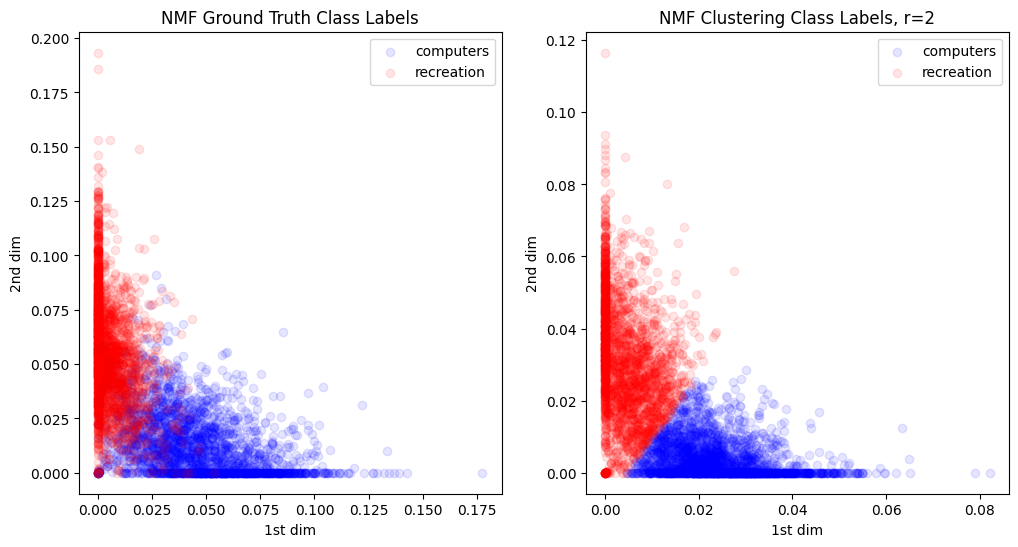

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

class_0_indices = np.where(class_labels == 0)[0]
class_1_indices = np.where(class_labels == 1)[0]
ax1.scatter(projected_base_nmf_data[class_0_indices,0],projected_base_nmf_data[class_0_indices,1],c='blue', alpha=0.1)
ax1.scatter(projected_base_nmf_data[class_1_indices,0],projected_base_nmf_data[class_1_indices,1],c='red', alpha=0.1)
ax1.legend(class_names)
ax1.set(xlabel='1st dim', ylabel='2nd dim', title='NMF Ground Truth Class Labels')

class_0_indices = np.where(optimal_nmf_labels == 0)[0]
class_1_indices = np.where(optimal_nmf_labels == 1)[0]
ax2.scatter(projected_optimal_nmf_data[class_0_indices,0],projected_optimal_nmf_data[class_0_indices,1],c='blue', alpha=0.1)
ax2.scatter(projected_optimal_nmf_data[class_1_indices,0],projected_optimal_nmf_data[class_1_indices,1],c='red', alpha=0.1)
ax2.legend(class_names)
ax2.set(xlabel='1st dim', ylabel='2nd dim', title=f'NMF Clustering Class Labels, r={ranges[best_nmf_scores_idx]}')
plt.show()

# Question 9
## What do you observe in the visualization? How are the data points of the two classes distributed?
For both SVD and NMF's projections we can see that the ground truth labels are comprised of two dense adjacent clusters with a significant overlap. There is no clear linear boundary between the data from the two classes.
## Is distribution of the data ideal for K-Means clustering?
This is problematic for K-means as the Euclidean distance metric will try to create a boundary and will misclassify the overlapping points on either side. Obviously this distribution is not ideal and it would be much better for K-means if the clusters could be geometrically separated.

# Question 10

In [166]:
# Import data
dataset_full = fetch_20newsgroups(subset='train', shuffle=True, random_state=seed, remove=('headers', 'footers'))
class_names = dataset_full.target_names
class_labels = dataset_full.target
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
full_train_tf_idf = vectorizer.fit_transform(dataset_full.data)
names = vectorizer.get_feature_names_out()
print(f'Shape of train TF-IDF matrix: {full_train_tf_idf.shape}')

Shape of train TF-IDF matrix: (11314, 33551)


In [167]:
# Get baseline TF-IDF labels
tf_idf_cluster_labels = KMeans(n_clusters=20, max_iter=2000, n_init=50, random_state=0).fit_predict(full_train_tf_idf)

# Search for best config again
ranges = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
svd_scores = []
nmf_scores = []
l, _ = reduce_dim_lsi(ranges[-1], full_train_tf_idf)
for r in tqdm(ranges):
    # Doing the SVD calculation manually instead of transform() so we can slice the number of components
    svd_representation = safe_sparse_dot(full_train_tf_idf, l.components_[:r].T)
    _, nmf_representation = reduce_dim_nmf(r, full_train_tf_idf)

    for rep, scores in zip([svd_representation, nmf_representation], [svd_scores, nmf_scores]):
        clustering = KMeans(n_clusters=20, max_iter=2000, n_init=50, random_state=0).fit(rep)
        cluster_labels = clustering.labels_
        scores.append(calculate_cluster_metrics(class_labels, cluster_labels))

100%|██████████| 13/13 [07:50<00:00, 36.18s/it]


In [168]:
# Show score for TF-IDF as a baseline (need this later for Q13).
print(f'\nDefault TF-IDF Performance:')
print_cluster_metrics(*calculate_cluster_metrics(class_labels,tf_idf_cluster_labels))

# Show best score for SVD
svd_scores_np = np.array(svd_scores)
best_svd_scores_idx = np.argmax(np.mean(svd_scores_np, axis=1))
print(f'\nBest SVD Scores r={ranges[best_svd_scores_idx]}:')
print_cluster_metrics(*svd_scores_np[best_svd_scores_idx,:])

# Show best score for NMF
nmf_scores_np = np.array(nmf_scores)
best_nmf_scores_idx = np.argmax(np.mean(nmf_scores_np, axis=1))
print(f'\nBest NMF Scores r={ranges[best_nmf_scores_idx]}:')
print_cluster_metrics(*nmf_scores_np[best_nmf_scores_idx,:])


Default TF-IDF Performance:
Homogeneity Score: 0.348
Completeness Score: 0.401
V-Measure Score: 0.373
Adjusted Rand Index: 0.123
Adjusted Mutual Information Score: 0.369
Mean score 0.323

Best SVD Scores r=100:
Homogeneity Score: 0.348
Completeness Score: 0.437
V-Measure Score: 0.387
Adjusted Rand Index: 0.104
Adjusted Mutual Information Score: 0.384
Mean score 0.332

Best NMF Scores r=5:
Homogeneity Score: 0.303
Completeness Score: 0.339
V-Measure Score: 0.320
Adjusted Rand Index: 0.104
Adjusted Mutual Information Score: 0.316
Mean score 0.276


In [169]:
# Project optimal data down twice with SVD
optimal_svd_reduced_data = TruncatedSVD(n_components=ranges[best_svd_scores_idx], random_state=seed).fit_transform(full_train_tf_idf)
optimal_svd_labels = KMeans(n_clusters=20, max_iter=2000, n_init=50, random_state=0).fit_predict(optimal_svd_reduced_data)

# Project optimal data down twice with NMF
optimal_nmf_reduced_data = NMF(n_components=ranges[best_nmf_scores_idx], random_state=seed).fit_transform(full_train_tf_idf)
optimal_nmf_labels = KMeans(n_clusters=20, max_iter=2000, n_init=50, random_state=0).fit_predict(optimal_nmf_reduced_data)

In [170]:
def get_contingency_matrix_trace(class_labels: np.ndarray, cluster_labels: np.ndarray):
    cont_matrix = contingency_matrix(class_labels, cluster_labels)
    rows, cols = linear_sum_assignment(cont_matrix, maximize=True)
    return np.trace(cont_matrix[:,cols])

def plot_contingency_matrix(class_labels: np.ndarray, cluster_labels: np.ndarray, title:str):
    cont_matrix = contingency_matrix(class_labels, cluster_labels)
    rows, cols = linear_sum_assignment(cont_matrix, maximize=True)
    plot_mat(cont_matrix[:,cols], xticklabels=rows, yticklabels=rows, size=(15,15), ylabel='class label', xlabel='cluster label', title=title)

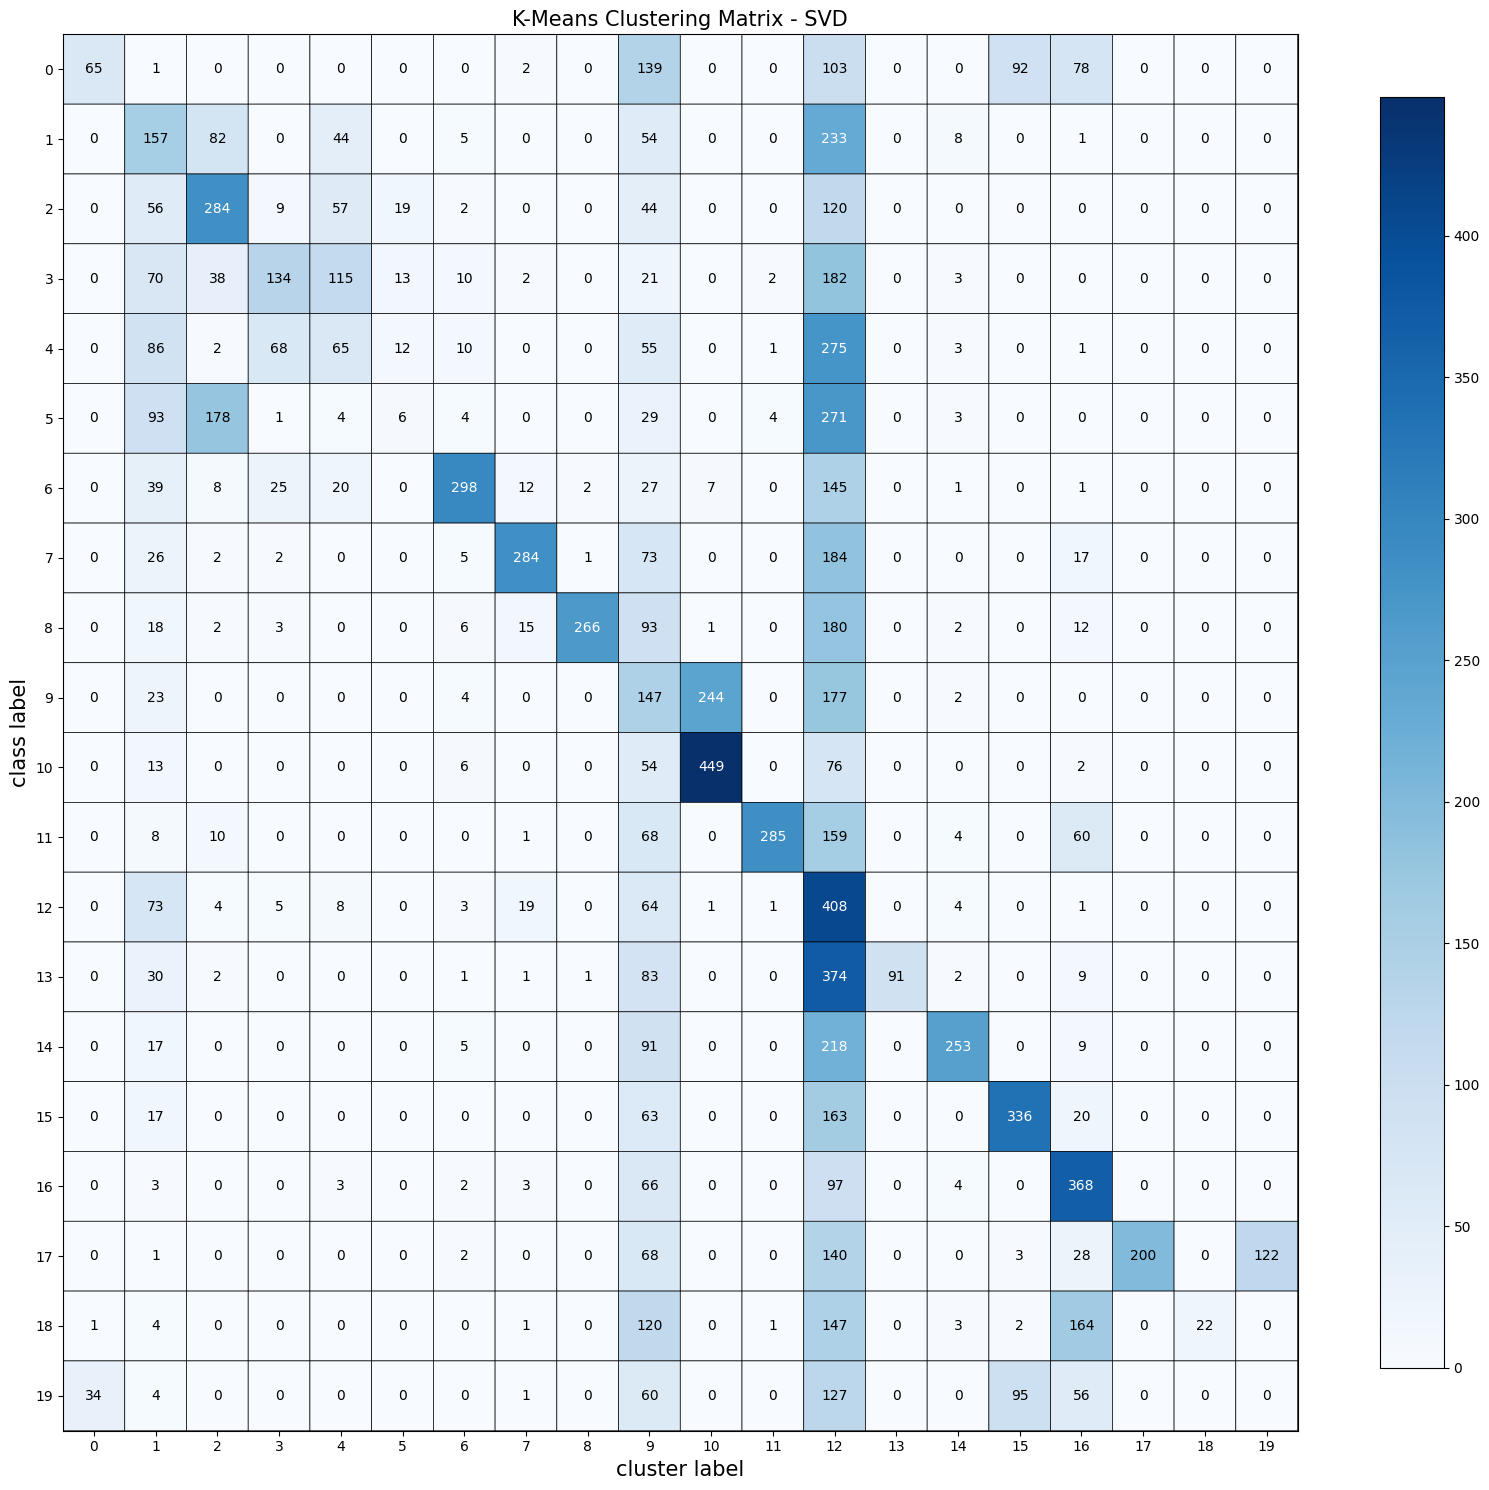

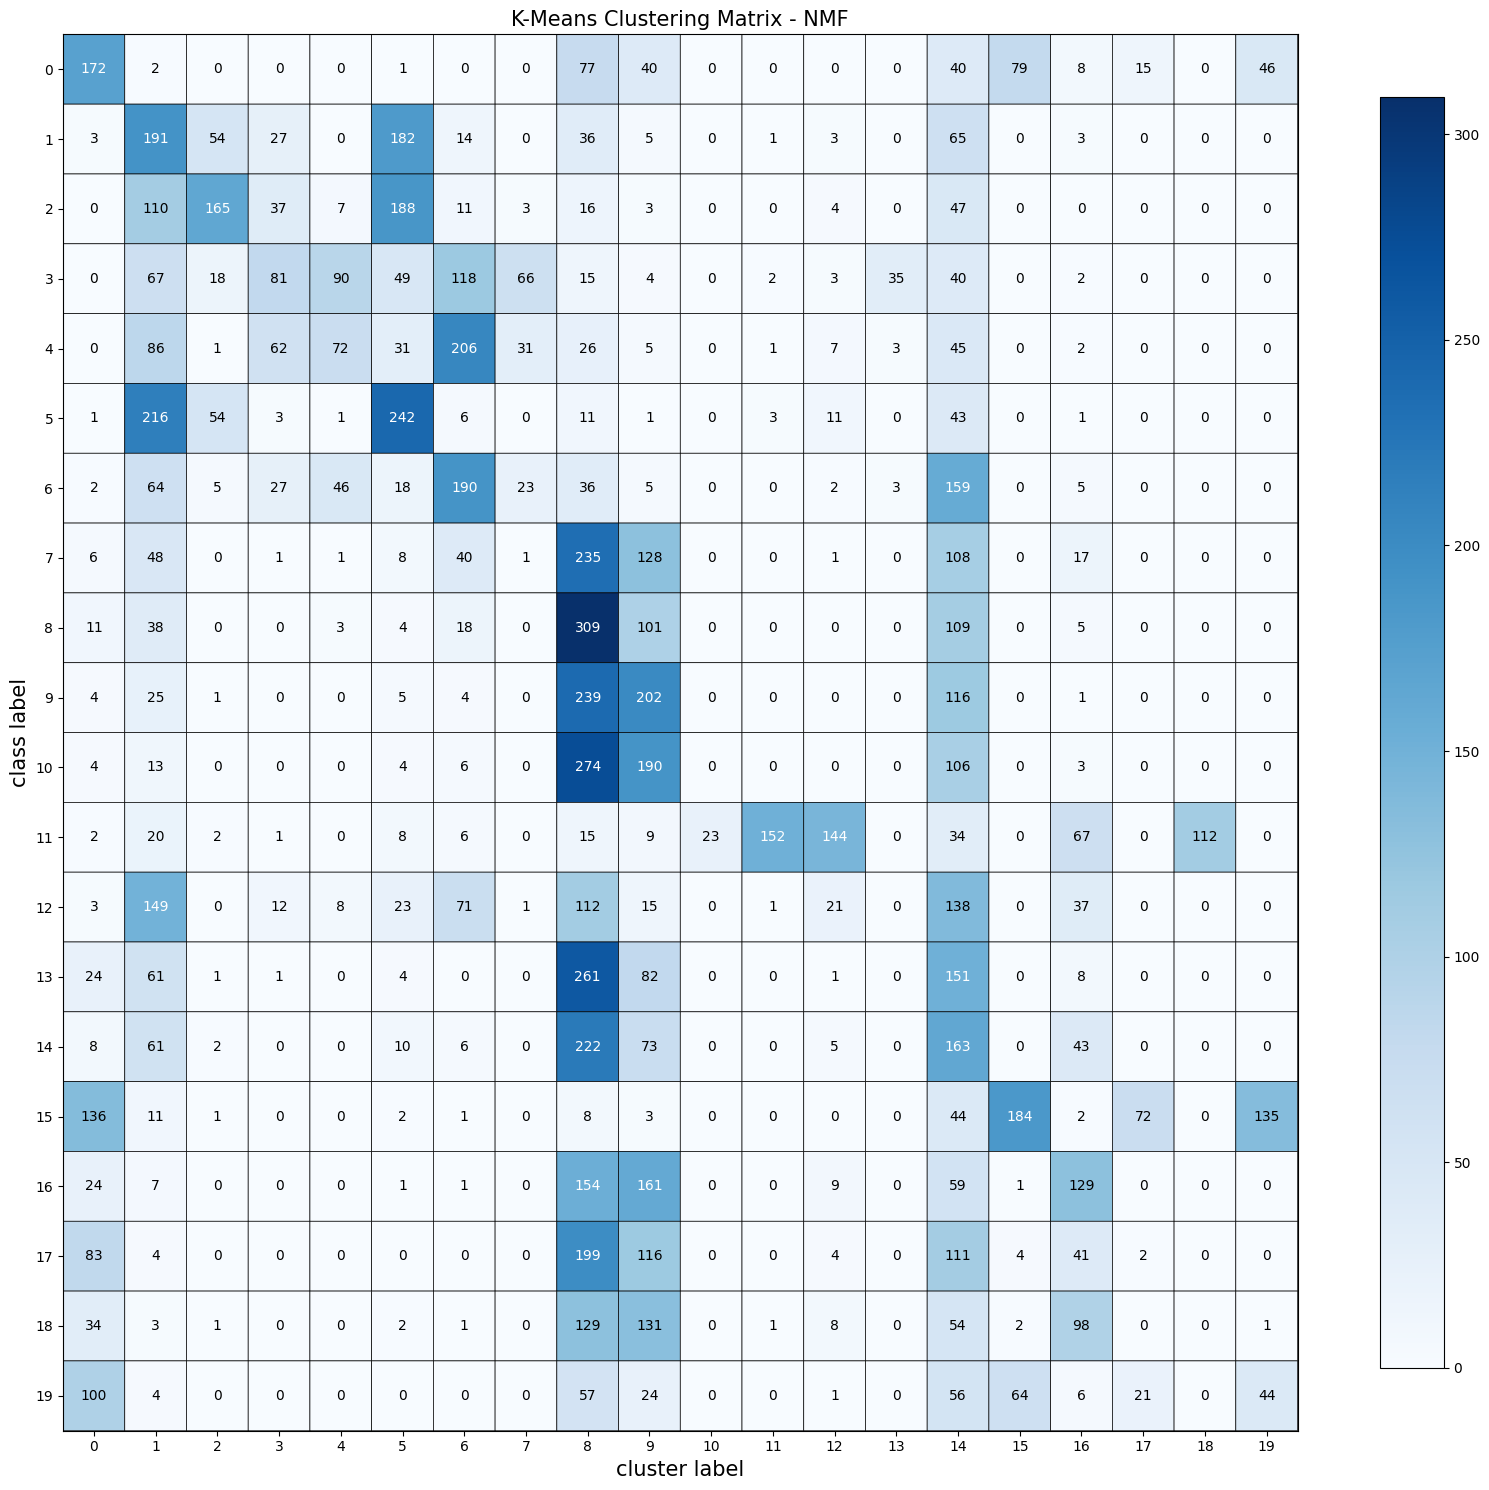

In [171]:
# Plot Contingency Matrix
plot_contingency_matrix(class_labels, optimal_svd_labels, 'K-Means Clustering Matrix - SVD')
plot_contingency_matrix(class_labels, optimal_nmf_labels, 'K-Means Clustering Matrix - NMF')

# Question 11

In [172]:
# UMAP search
n_components = [5, 20, 200]
metrics = ['cosine', 'euclidean']
search_configs = []
search_cluster_labels = []
for n_c, m in tqdm(list(itertools.product(n_components, metrics))):
        umap = UMAP(random_state=seed, n_components=n_c, metric=m, n_jobs=8)
        reduced_data = umap.fit_transform(full_train_tf_idf)
        cluster_labels = KMeans(n_clusters=20, max_iter=2000, n_init=50, random_state=0).fit_predict(reduced_data)
        search_configs.append((n_c, m))
        search_cluster_labels.append(cluster_labels)

100%|██████████| 6/6 [05:05<00:00, 50.96s/it]



==UMAP Performance (n_components=5, metric=cosine)==
Homogeneity Score: 0.572
Completeness Score: 0.592
V-Measure Score: 0.582
Adjusted Rand Index: 0.444
Adjusted Mutual Information Score: 0.580
Mean score 0.554
Trace: 6724


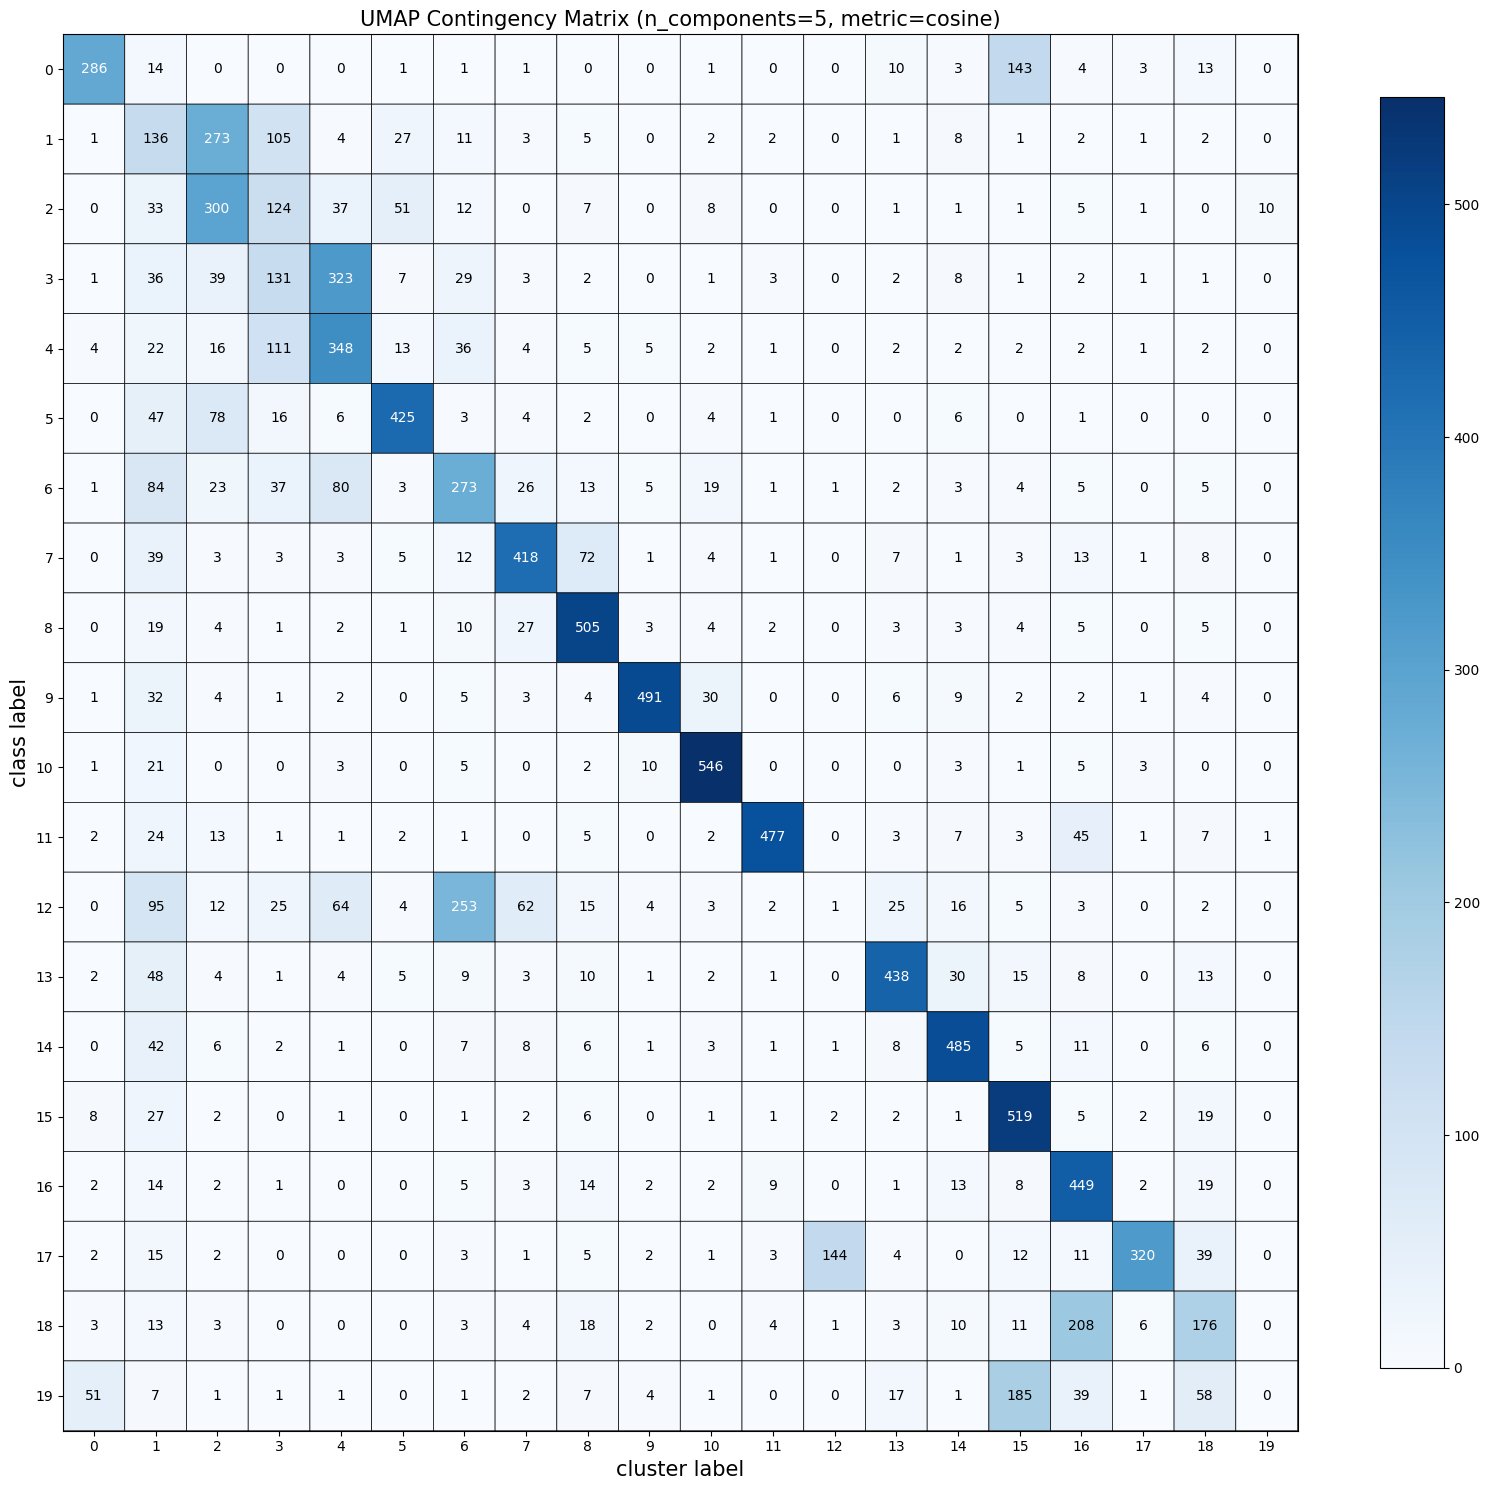


==UMAP Performance (n_components=5, metric=euclidean)==
Homogeneity Score: 0.009
Completeness Score: 0.009
V-Measure Score: 0.009
Adjusted Rand Index: 0.001
Adjusted Mutual Information Score: 0.003
Mean score 0.006
Trace: 804


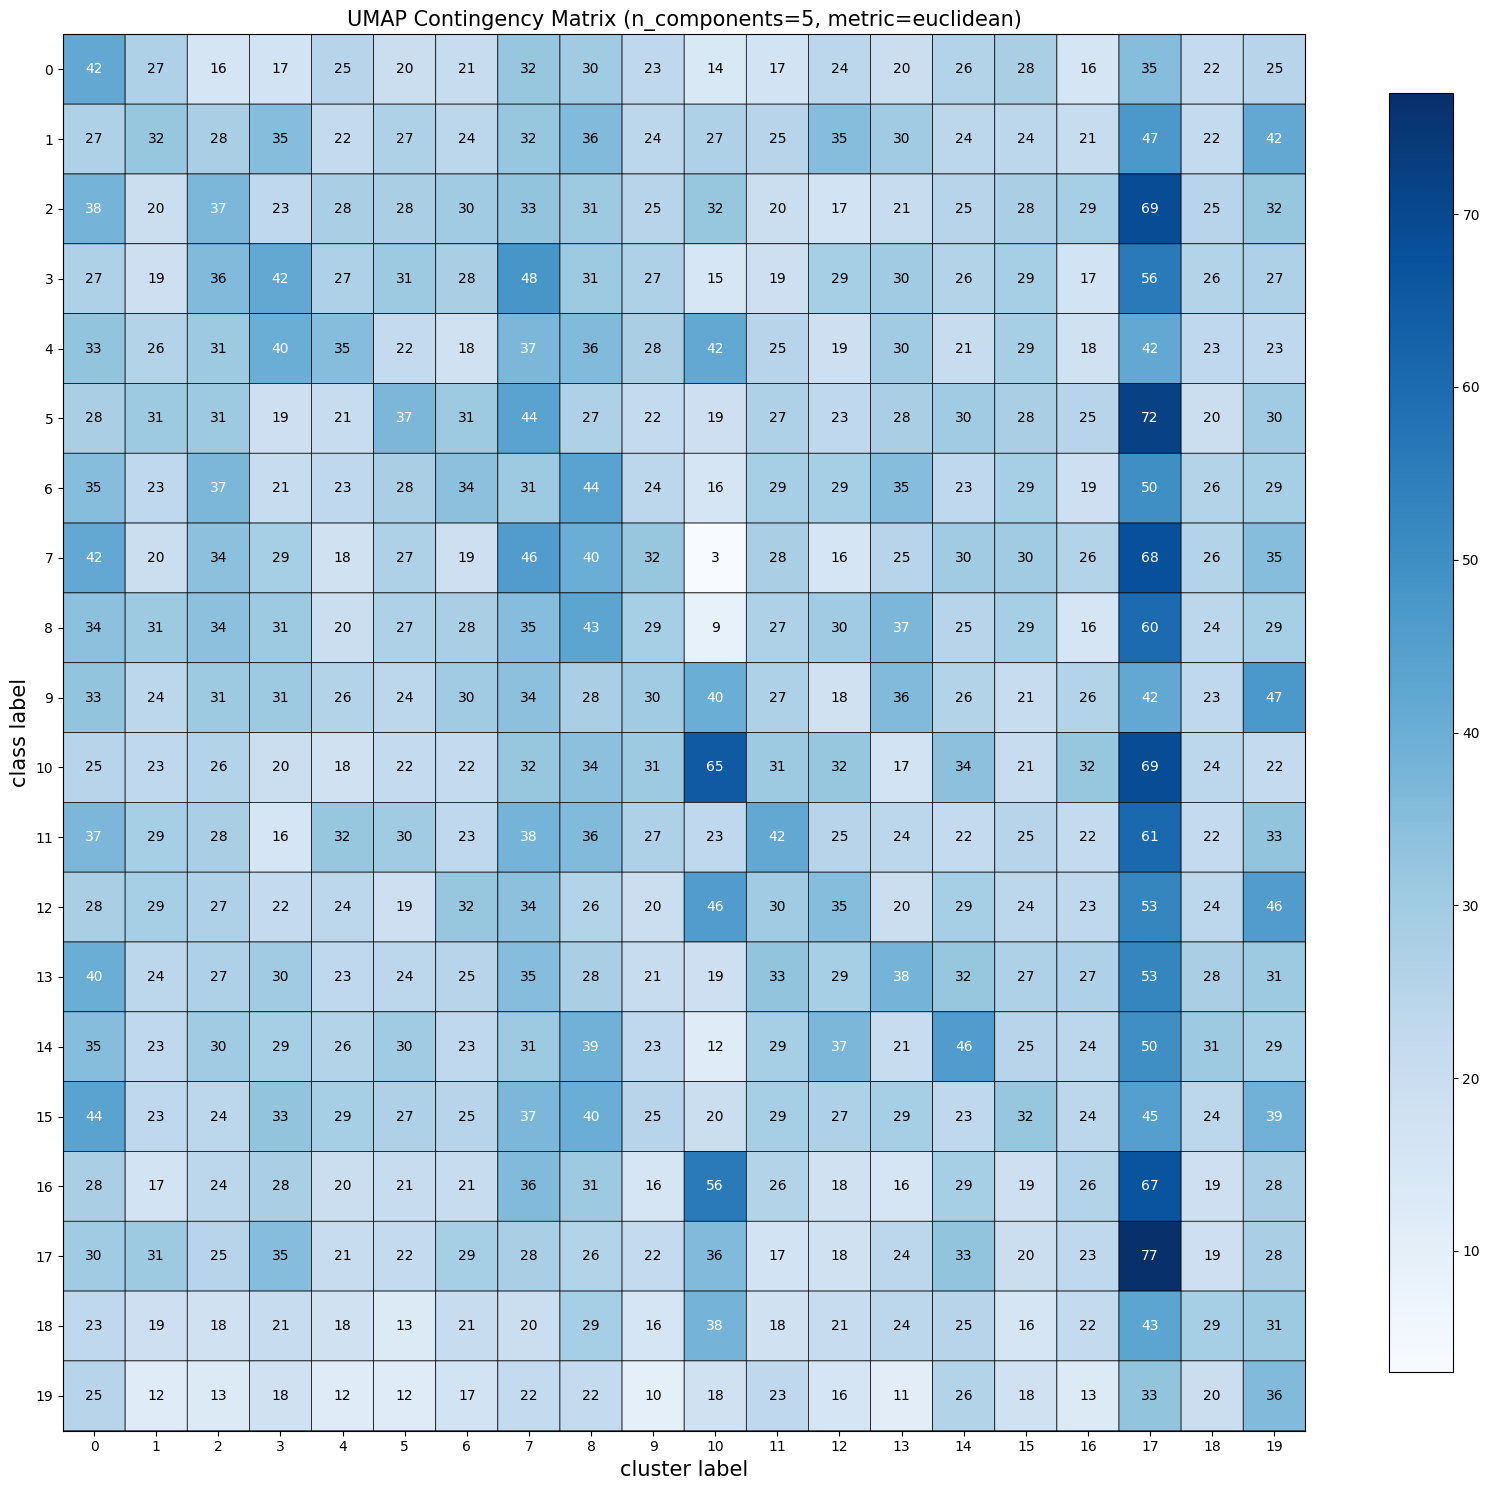


==UMAP Performance (n_components=20, metric=cosine)==
Homogeneity Score: 0.577
Completeness Score: 0.595
V-Measure Score: 0.586
Adjusted Rand Index: 0.450
Adjusted Mutual Information Score: 0.584
Mean score 0.558
Trace: 6878


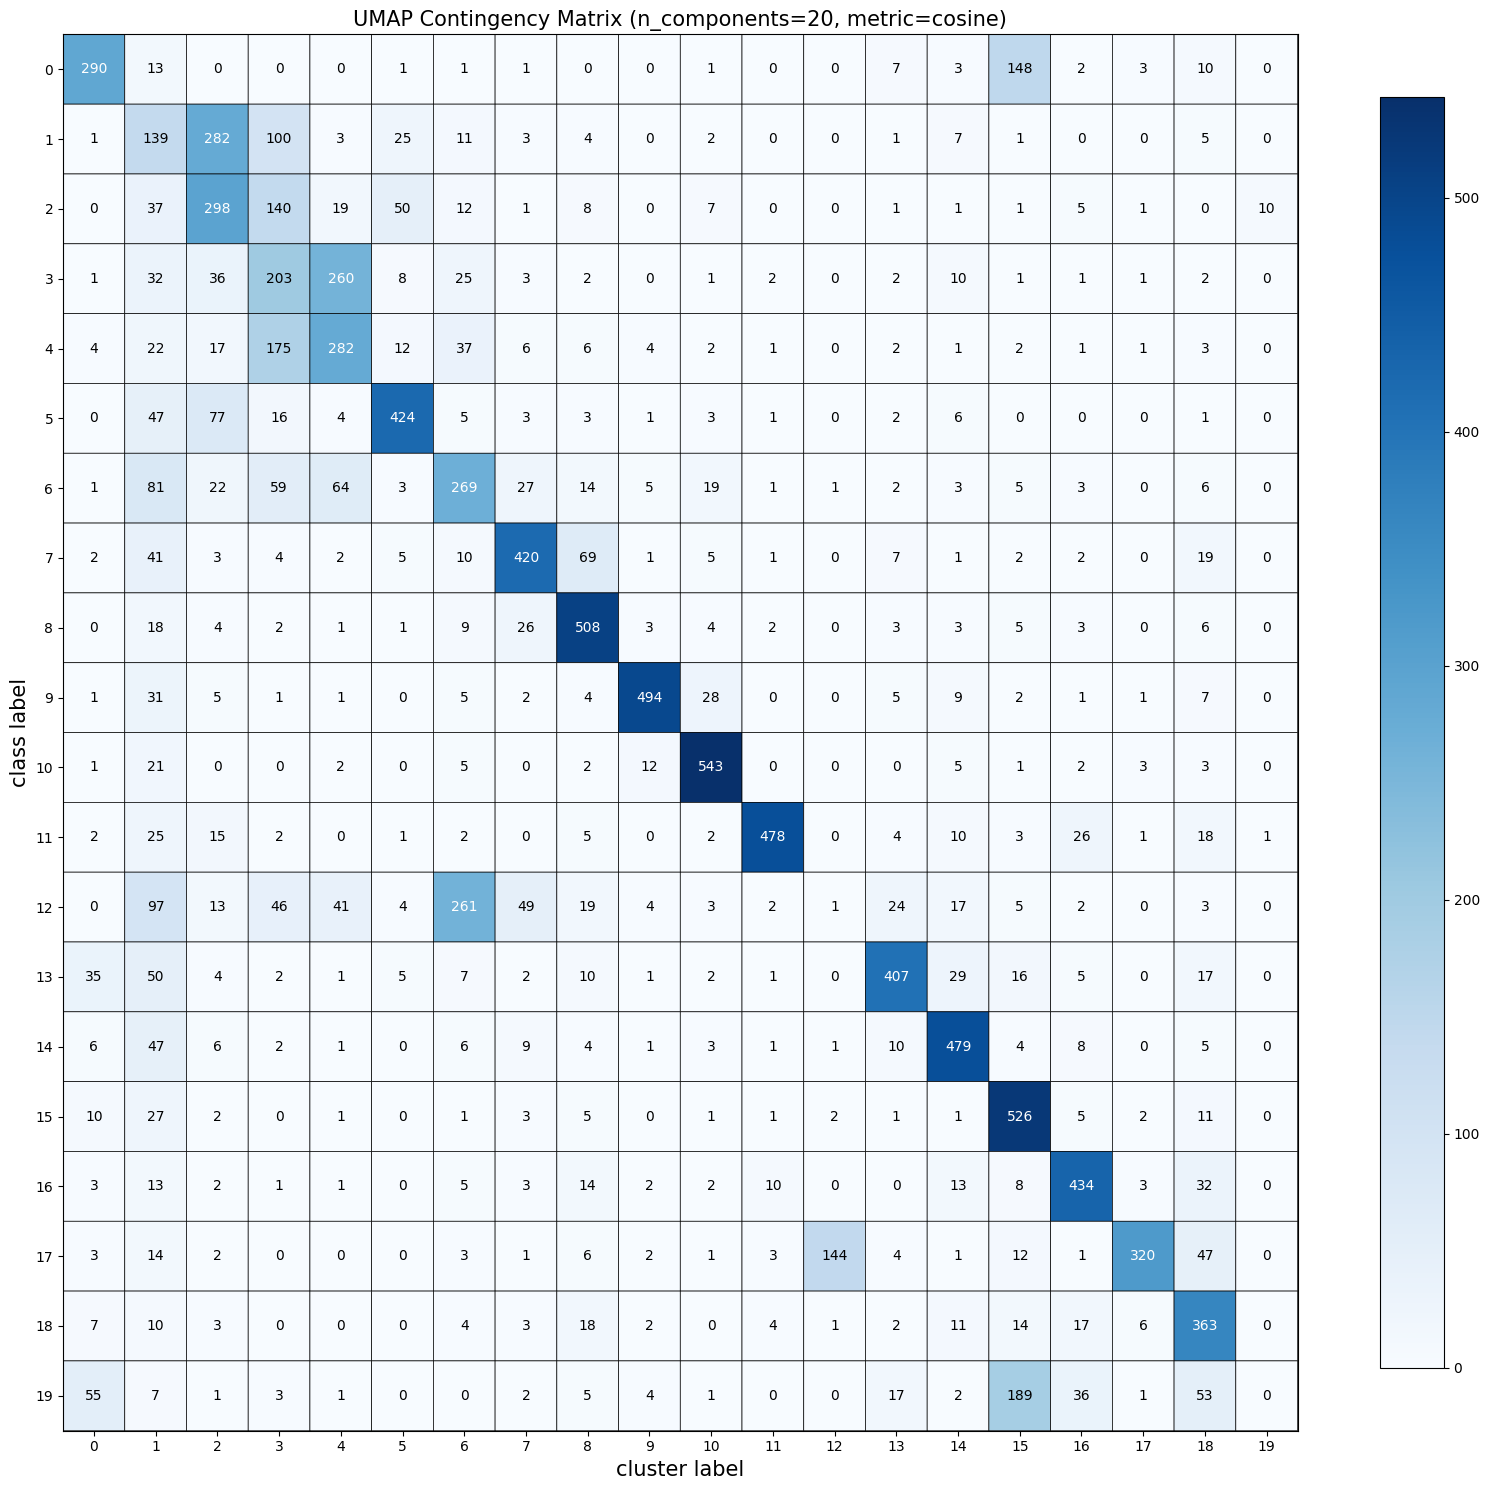


==UMAP Performance (n_components=20, metric=euclidean)==
Homogeneity Score: 0.010
Completeness Score: 0.010
V-Measure Score: 0.010
Adjusted Rand Index: 0.001
Adjusted Mutual Information Score: 0.004
Mean score 0.007
Trace: 792


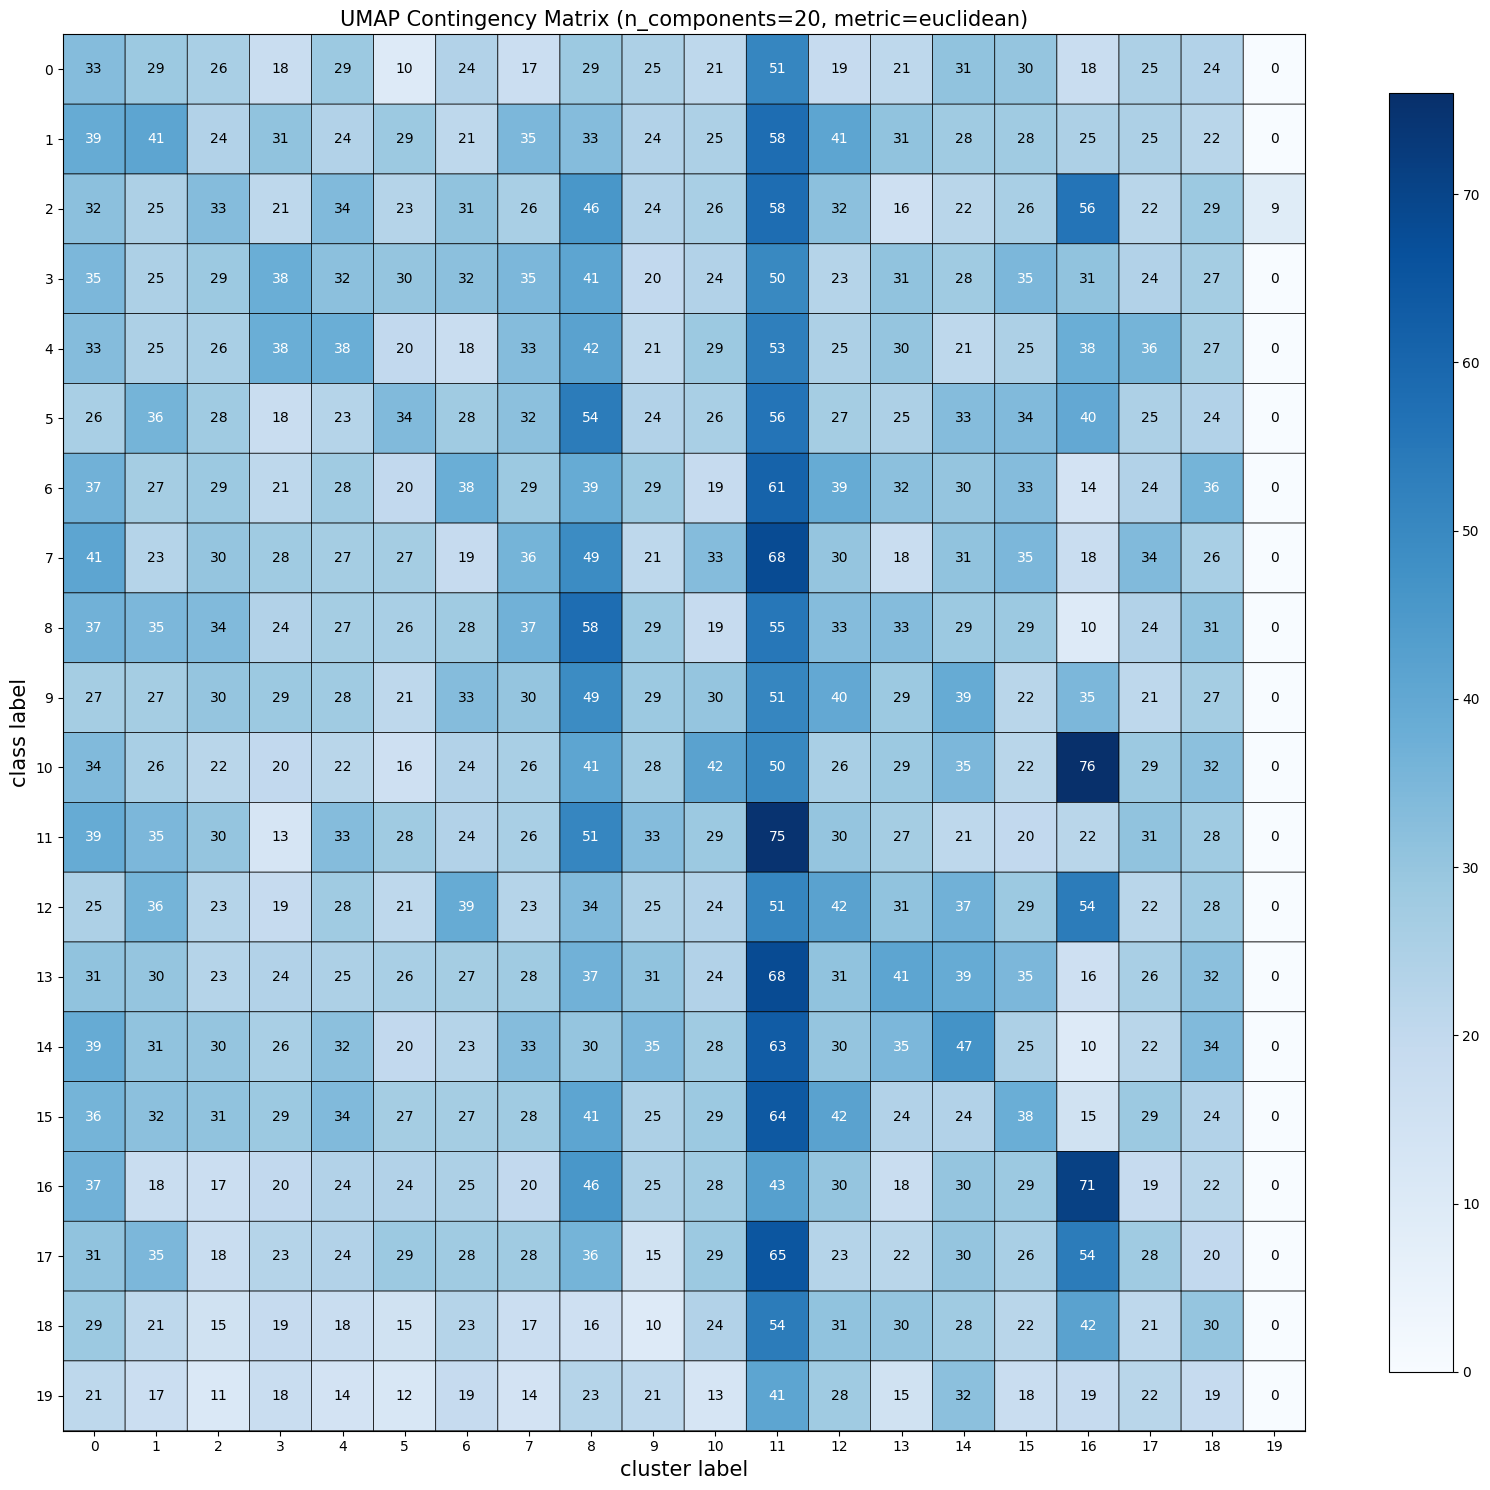


==UMAP Performance (n_components=200, metric=cosine)==
Homogeneity Score: 0.575
Completeness Score: 0.600
V-Measure Score: 0.587
Adjusted Rand Index: 0.451
Adjusted Mutual Information Score: 0.585
Mean score 0.560
Trace: 6846


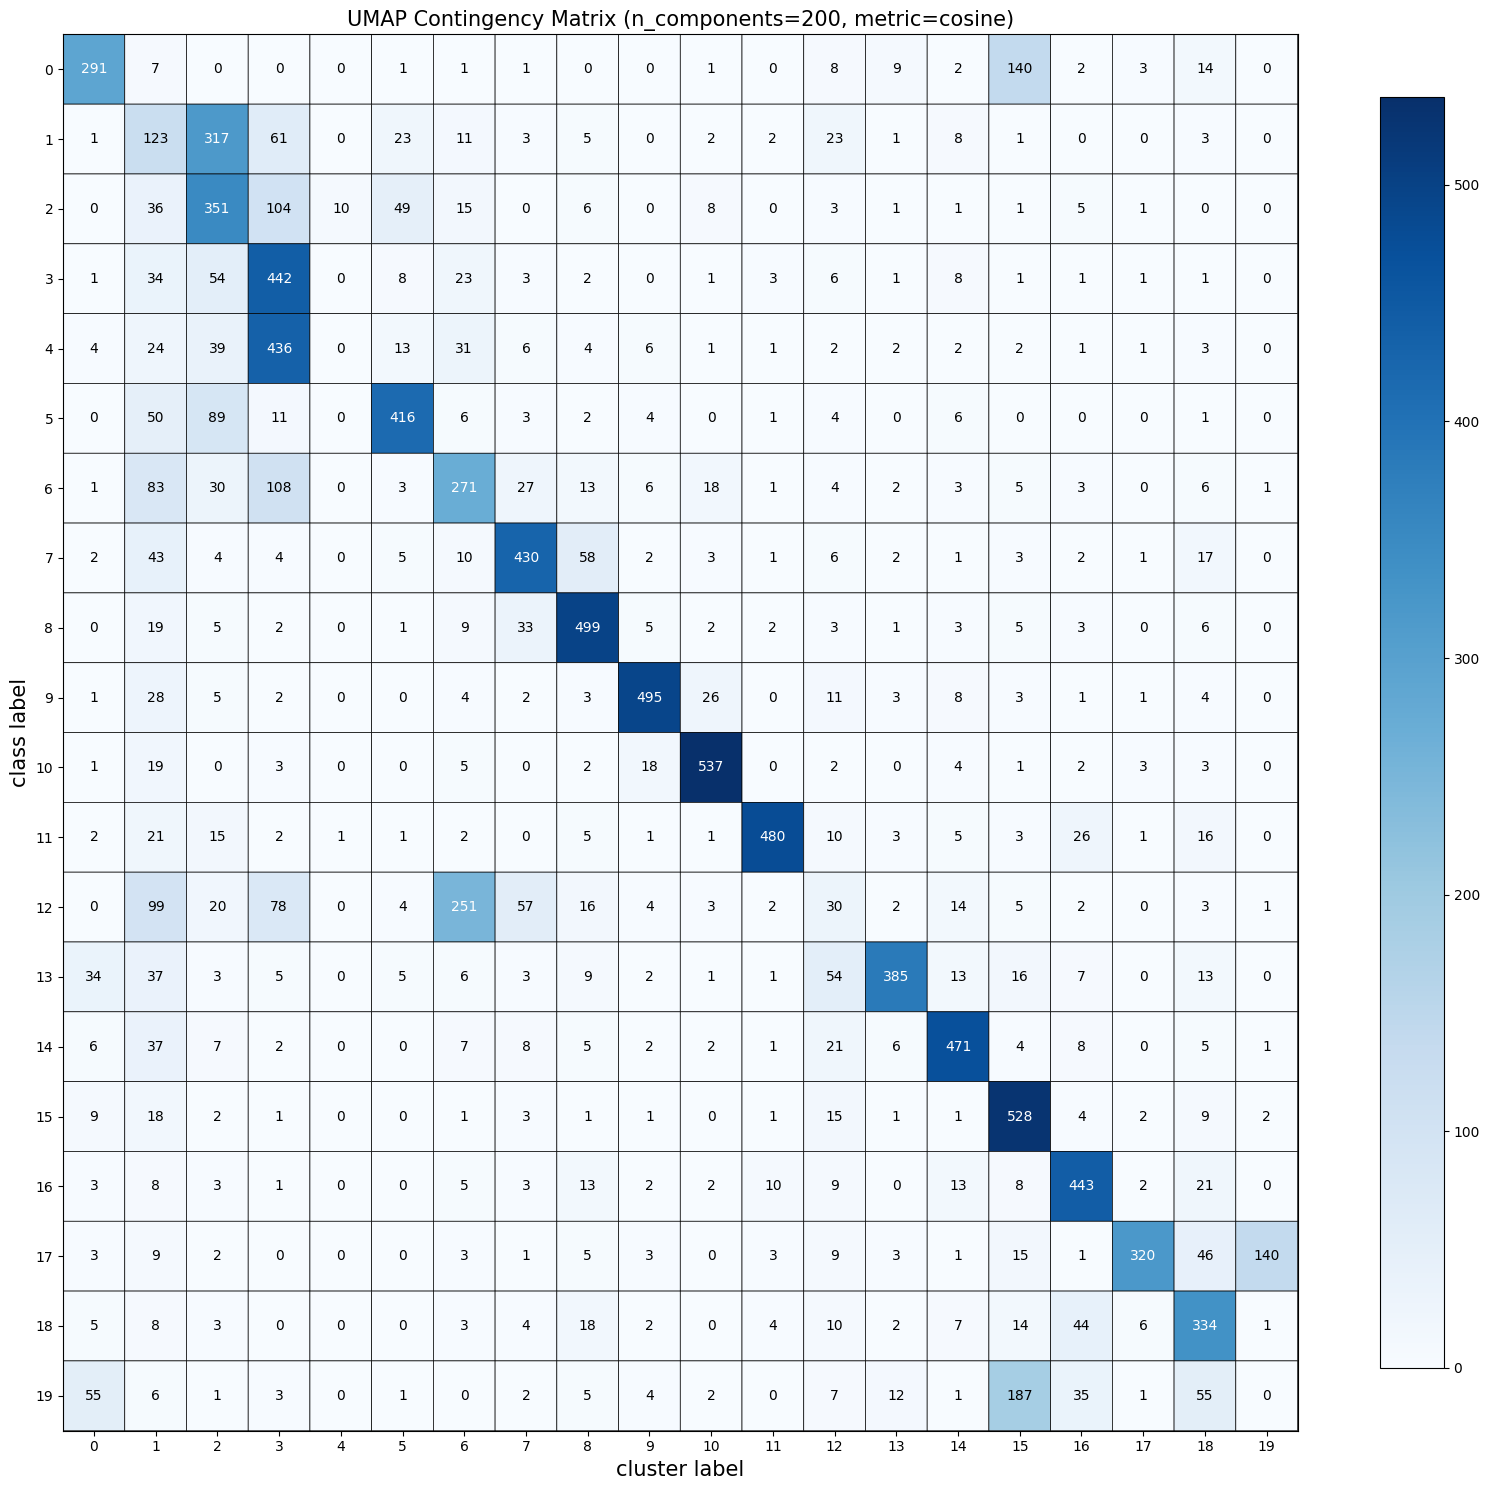


==UMAP Performance (n_components=200, metric=euclidean)==
Homogeneity Score: 0.009
Completeness Score: 0.009
V-Measure Score: 0.009
Adjusted Rand Index: 0.001
Adjusted Mutual Information Score: 0.004
Mean score 0.007
Trace: 794


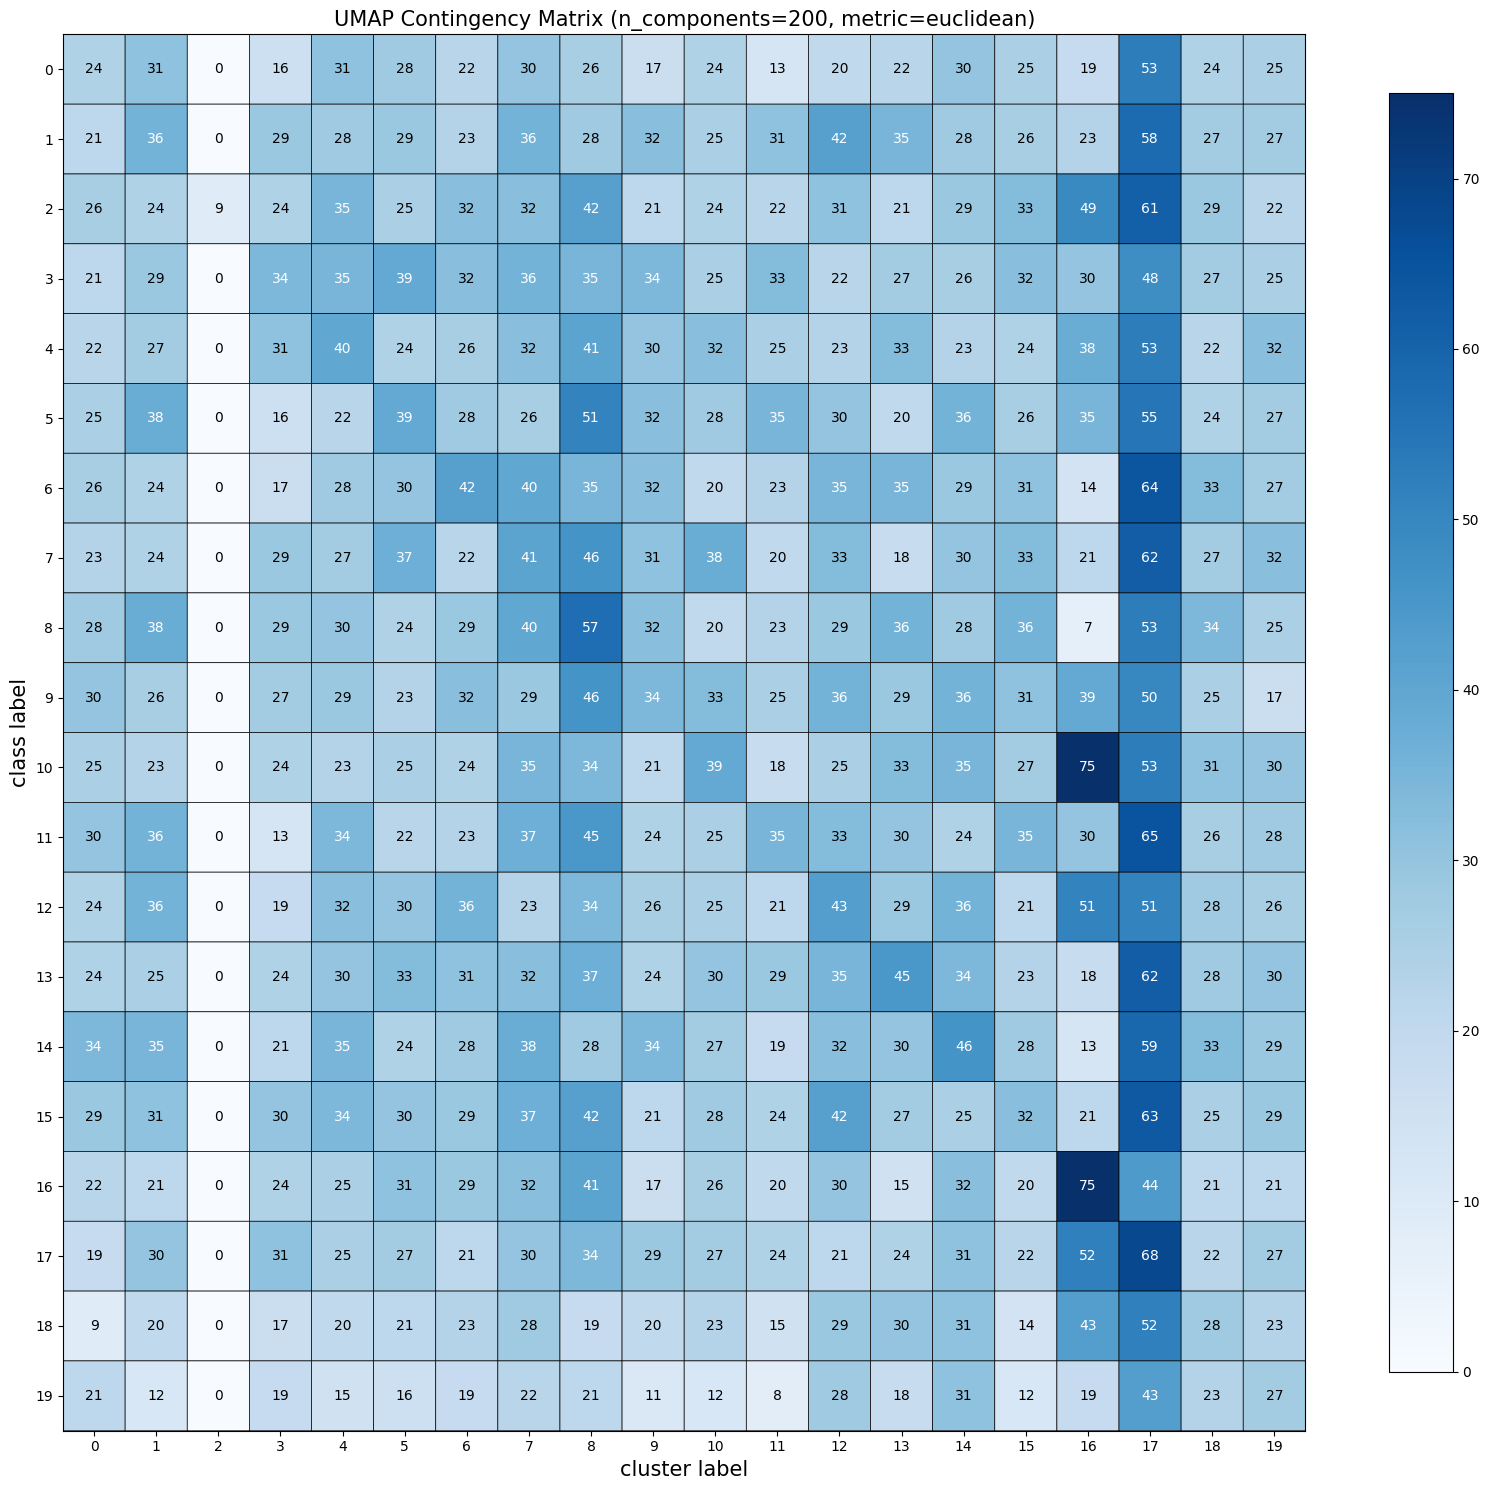

In [173]:
# UMAP results
for conf, cluster_labels in zip(search_configs, search_cluster_labels):
    n_components, metric = conf
    conf_str = f'n_components={n_components}, metric={metric}'
    print(f'\n==UMAP Performance ({conf_str})==')
    print_cluster_metrics(*calculate_cluster_metrics(class_labels, cluster_labels))
    print(f'Trace: {get_contingency_matrix_trace(class_labels, cluster_labels)}')
    plot_contingency_matrix(class_labels, cluster_labels, f'UMAP Contingency Matrix ({conf_str})')

# Question 12
## Which setting works best and why?
We can generally observe that distance `metric` is the most significant factor in deciding the clustering result, whereas the effect of `n_components` is fairly marginal. From both the contingency matrices (which can be compared for accuracy using their traces) and the 5 clustering metrics the cosine distance metric is vastly superior. Increasing the number of components also has a positive, but comparatively minor effect. As for why, this is likely the normalising effect of cosine distances, that makes it possible to compare TF-IDF rows with vastly different word counts in a meaningful way. The difference in outcome is quite significant, as can be shown when we project the clusters down below.

In [174]:
# Cosine data
optimal_cosine_umap_data = UMAP(random_state=seed, n_components=200, metric='cosine', n_jobs=8).fit_transform(full_train_tf_idf)
projected_cosine_umap_data = UMAP(random_state=seed, n_components=2, metric='cosine', n_jobs=8).fit_transform(optimal_cosine_umap_data)

# Euclidean data
optimal_euclidean_umap_data = UMAP(random_state=seed, n_components=200, metric='euclidean', n_jobs=8).fit_transform(full_train_tf_idf)
projected_euclidean_umap_data = UMAP(random_state=seed, n_components=2, metric='euclidean', n_jobs=8).fit_transform(optimal_euclidean_umap_data)

<Figure size 640x480 with 0 Axes>

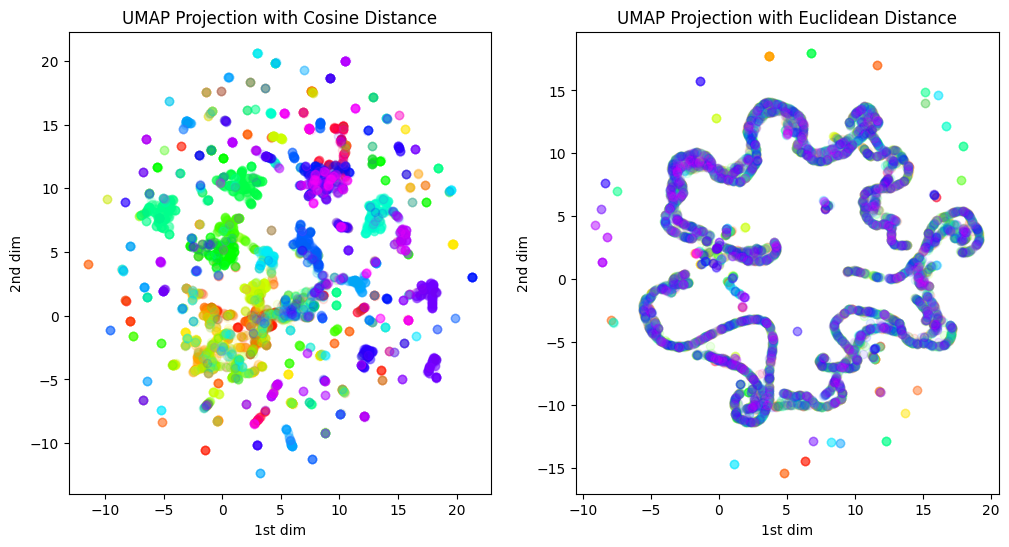

In [175]:
NUM_COLORS = len(class_names)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(0, len(class_names)):
    class_i_indices = np.where(class_labels == i)[0]
    ax1.scatter(projected_cosine_umap_data[class_i_indices,0],projected_cosine_umap_data[class_i_indices,1], alpha=0.1)

ax1.set(xlabel='1st dim', ylabel='2nd dim', title='UMAP Projection with Cosine Distance')

ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(0, len(class_names)):
    class_i_indices = np.where(class_labels == i)[0]
    ax2.scatter(projected_euclidean_umap_data[class_i_indices,0],projected_euclidean_umap_data[class_i_indices,1], alpha=0.1)

ax2.set(xlabel='1st dim', ylabel='2nd dim', title='UMAP Projection with Euclidean Distance')
plt.show()

## What about for each metric choice?
Again UMAP with cosine distance dominates the Euclidean distance across all 5 metrics by a considerable margin.

# Question 13
We will compare the 4 dimensionality reduction methods using the Adjusted Rand Index (ARI), as it ultimately reflects how well K-Means is able to split up classes into respective clusters, given the representation from a method.
- **TF-IDF** has an ARI of 0.123.
- **Truncated SVD** has an ARI of 0.104.
- **NMF** has an ARI of 0.104.
- **UMAP + Cosine** has an ARI of 0.585.

A random labelling would yield and ARI of 0, whereas a perfect labelling yields 1. It's pretty clear that aside from UMAP + Cosine, the other reductions yield cluster labels that are not much better than random chance and worse than not reducing the dimensionality at all. Accordingly, the best approach for clustering these 20 classes via K-Mean is to use a UMAP reduction using cosine distances with a final feature size of 200 dimensions.

# Question 14

In [176]:
# Agglomerative Clustering Search
param_grid = {
    'n_components': [5, 50, 200],
    'linkage': ['ward', 'single']
}
search_configs = []
search_cluster_labels = []

for g in tqdm(ParameterGrid(param_grid=param_grid)):
    umap = UMAP(random_state=seed, n_components=g['n_components'], metric='cosine', n_jobs=8)
    reduced_data = umap.fit_transform(full_train_tf_idf)
    cluster_labels = AgglomerativeClustering(n_clusters=20, linkage=g['linkage']).fit_predict(reduced_data)
    search_configs.append(g)
    search_cluster_labels.append(cluster_labels)

100%|██████████| 6/6 [03:36<00:00, 36.13s/it]


In [177]:
# Agglomerative Clustering results
for conf, cluster_labels in zip(search_configs, search_cluster_labels):
    print(f'\n==Agglomerative Clustering Performance ({conf})==')
    print_cluster_metrics(*calculate_cluster_metrics(class_labels, cluster_labels))


==Agglomerative Clustering Performance ({'linkage': 'ward', 'n_components': 5})==
Homogeneity Score: 0.562
Completeness Score: 0.582
V-Measure Score: 0.572
Adjusted Rand Index: 0.426
Adjusted Mutual Information Score: 0.569
Mean score 0.542

==Agglomerative Clustering Performance ({'linkage': 'ward', 'n_components': 50})==
Homogeneity Score: 0.551
Completeness Score: 0.574
V-Measure Score: 0.562
Adjusted Rand Index: 0.410
Adjusted Mutual Information Score: 0.560
Mean score 0.531

==Agglomerative Clustering Performance ({'linkage': 'ward', 'n_components': 200})==
Homogeneity Score: 0.552
Completeness Score: 0.574
V-Measure Score: 0.563
Adjusted Rand Index: 0.413
Adjusted Mutual Information Score: 0.560
Mean score 0.532

==Agglomerative Clustering Performance ({'linkage': 'single', 'n_components': 5})==
Homogeneity Score: 0.022
Completeness Score: 0.410
V-Measure Score: 0.042
Adjusted Rand Index: 0.001
Adjusted Mutual Information Score: 0.034
Mean score 0.102

==Agglomerative Clustering

## Compare the performance of “ward” and “single” linkage criteria
We can see here that the linkage plays the biggest role in the agglomeration. The single linkage does not perform well because its merging rule ends up putting most of the datapoints into the same cluster. The ward linkage generally performs better as its constraint minimises the distances within clusters, which encourages more similarly populated and denser clusters.

# Question 15

In [178]:
# HDBSCAN Clustering Search
param_grid = {
    'min_cluster_size': [20, 100, 200],
}
search_configs = []
search_cluster_labels = []

for g in tqdm(ParameterGrid(param_grid=param_grid)):
    umap = UMAP(random_state=seed, n_components=200, metric='cosine', n_jobs=8)
    reduced_data = umap.fit_transform(full_train_tf_idf)
    cluster_labels =  hdbscan.HDBSCAN(min_cluster_size=g['min_cluster_size']).fit_predict(reduced_data)
    search_configs.append(g)
    search_cluster_labels.append(cluster_labels)

100%|██████████| 3/3 [03:38<00:00, 72.83s/it]


In [179]:
# HDBSCAN Clustering results
for conf, cluster_labels in zip(search_configs, search_cluster_labels):
    print(f'\n==HDBSCAN Performance ({conf})==')
    print_cluster_metrics(*calculate_cluster_metrics(class_labels, cluster_labels))


==HDBSCAN Performance ({'min_cluster_size': 20})==
Homogeneity Score: 0.442
Completeness Score: 0.497
V-Measure Score: 0.468
Adjusted Rand Index: 0.122
Adjusted Mutual Information Score: 0.457
Mean score 0.397

==HDBSCAN Performance ({'min_cluster_size': 100})==
Homogeneity Score: 0.407
Completeness Score: 0.602
V-Measure Score: 0.486
Adjusted Rand Index: 0.191
Adjusted Mutual Information Score: 0.484
Mean score 0.434

==HDBSCAN Performance ({'min_cluster_size': 200})==
Homogeneity Score: 0.323
Completeness Score: 0.607
V-Measure Score: 0.422
Adjusted Rand Index: 0.131
Adjusted Mutual Information Score: 0.420
Mean score 0.380


# Question 16

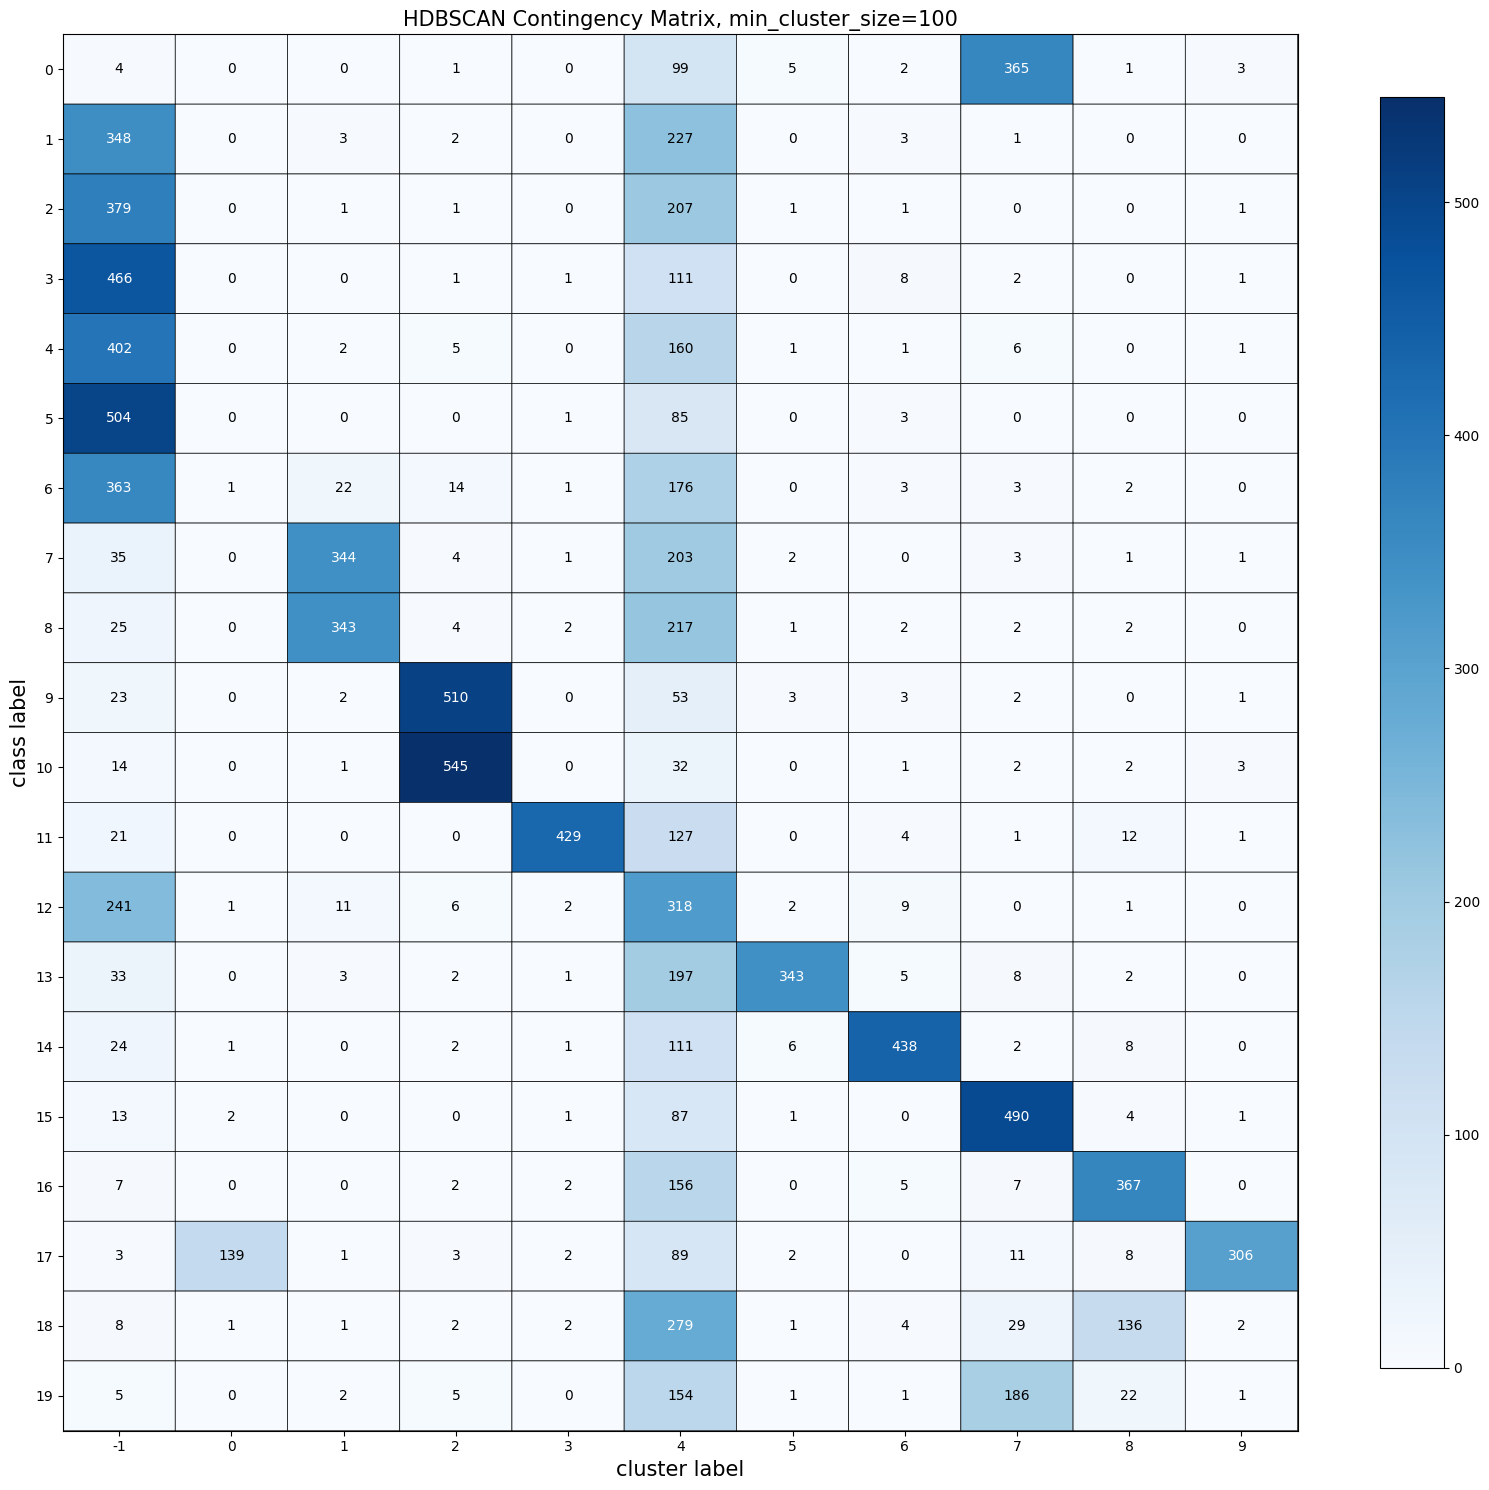

In [180]:
def plot_rectangular_contingency_matrix(class_labels: np.ndarray, cluster_labels: np.ndarray, title:str):
    cont_matrix = contingency_matrix(class_labels, cluster_labels)
    rows, cols = linear_sum_assignment(cont_matrix, maximize=True)
    plot_mat(cont_matrix[:,cols], xticklabels=np.unique(cluster_labels), yticklabels=range(0, cont_matrix.shape[0]), size=(15,15), ylabel='class label', xlabel='cluster label', title=title)

plot_rectangular_contingency_matrix(class_labels, search_cluster_labels[1], 'HDBSCAN Contingency Matrix, min_cluster_size=100')

## How many clusters are given by the model? What does “-1” mean for the clustering labels?
We can see from the above that this HDBSCAN configuration has chosen there to be 10 clusters dense enough to be distinct classes. This is less than the actual number of classes (20) and can be explained by most datapoints from classes 1-6 being labelled as "noise" (the -1 label). Additionally, it has put a chunk of all other classes into the 4th cluster and mapped classes 0 and 15 to the 7th cluster. Overall the contingency matrix suggests that we may wish to try minimum cluster sizes between 20 and 100 to get a more desirable number. Although likely a few other parameters should be adjusted as well.

# Question 17

In [181]:
# Lazy cache that stores all pairings of data + dimensionality reduction
# Works if you have enough RAM
lazy_cache = {}

In [182]:
# Define parameter grid
svd_variants = [TruncatedSVD(n_components=r, random_state=seed) for r in [5, 20, 200]]
nmf_variants = [NMF(n_components=r, init='random', random_state=seed, max_iter=500) for r in [5, 20, 200]]
umap_variants = [UMAP(random_state=seed, n_components=n, metric='cosine', n_jobs=8) for n in [5, 20, 200]]
no_dim = [None]

kmeans_variants = [KMeans(n_clusters=k, max_iter=2000, n_init=50, random_state=0) for k in [10, 20, 50]]
agglomerative_variants = [AgglomerativeClustering(n_clusters=20, linkage='ward')]
hdbscan_variants = [hdbscan.HDBSCAN(min_cluster_size=m) for m in [50, 75, 100, 200]]

param_grid = {
    # 'data_source': [summarised_train_tf_idf, full_train_tf_idf],
    'data_source': [full_train_tf_idf],
    'dim_reduction': svd_variants + nmf_variants + umap_variants + no_dim,
    'clustering': kmeans_variants + agglomerative_variants + hdbscan_variants
}
search_configs = []
search_cluster_labels = []

parameter_grid = list(ParameterGrid(param_grid=param_grid))
# This is a special case we have to skip over as agglomerative clustering does not work for sparse matrices
# And we cannot to dense ones given the enormous memory cost.
parameter_grid = [g for g in parameter_grid
                  if not (type(g['clustering']).__name__  == 'AgglomerativeClustering' and g['dim_reduction'] == None)]

# Search over possible cases
for g in tqdm(parameter_grid):
    data = g['data_source']

    if g['dim_reduction']:
        cache_str = f"{id(g['data_source'])}-{id(g['dim_reduction'])}"
        if cache_str not in lazy_cache:
            lazy_cache[cache_str] = g['dim_reduction'].fit_transform(data)
        reduced_data = lazy_cache[cache_str]
    else:
        reduced_data = data

    cluster_labels = g['clustering'].fit_predict(reduced_data)
    search_configs.append(g)
    search_cluster_labels.append(cluster_labels)

100%|██████████| 79/79 [25:25<00:00, 19.32s/it]  


In [183]:
search_scores = np.array([calculate_cluster_metrics(class_labels, c_l) for c_l in search_cluster_labels])
top_5_indices = np.argsort(search_scores[:,4])[-5:]

for i in top_5_indices:
    print()
    print(search_configs[i])
    print_cluster_metrics(*search_scores[i])


{'clustering': AgglomerativeClustering(n_clusters=20), 'data_source': <11314x33551 sparse matrix of type '<class 'numpy.float64'>'
	with 927971 stored elements in Compressed Sparse Row format>, 'dim_reduction': UMAP(angular_rp_forest=True, metric='cosine', n_components=20, n_jobs=8, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})}
Homogeneity Score: 0.552
Completeness Score: 0.584
V-Measure Score: 0.568
Adjusted Rand Index: 0.412
Adjusted Mutual Information Score: 0.565
Mean score 0.536

{'clustering': AgglomerativeClustering(n_clusters=20), 'data_source': <11314x33551 sparse matrix of type '<class 'numpy.float64'>'
	with 927971 stored elements in Compressed Sparse Row format>, 'dim_reduction': UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=8, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'de

Comparing the search results based on the mean of all metrics, we can see that consistently the best dimensionality reduction method is UMAP with the cosine metric. As this mostly confirms earlier observations on Euclidean vs cosine distance, this is not too surprising. Otherwise, the best clustering algorithm was K-Means followed closely by Agglomerative Clustering. This isn't too surprising as the "ward" linkage rule is quite similar to K-Means' objective function. The absence of HDBScan on the other hand suggests that it likely was not able to guess the exact right number of classes, so it performed worse. To be fair, the other two approaches have an advantage by having this information, which they wouldn't normally in unsupervised learning.

# Question 18
Nothing significant to report. Some experiments were run to summarise texts using a large language model (BART) before passing them into TF-IDF. The idea was that they would remove a lot of the junk symbols and irrelevant names - which they did - reducing the number of features in the TF-IDF by a factor of 4. However, the Q17 pipeline did not yield any good results with this shortened dataset, so it is likely too many context words were removed. It's likely this could be improved, but the generation of the summaries takes several hours each time and it's not reasonable to tune within the timeframe of the assignment.

# Question 19
The reason why we can use the VGGNet for different image tasks than it was originally trained for, is that there are some common subtasks across all image classification tasks that a model has to learn. Such a subtask can be recognising an edge striping pattern or a circle. Regardless of whether we classify cats, flowers or spacecraft, being able to recognise basic visual patterns is transferable between tasks. As for how this works in the context of feature extraction, the initial layers learn how to extract simple features such as aforementioned edges. Intermediate layers can then aggregate this into higher-level features such as an eye. The final layers then extract the most high-level features such as a face or tail in the case of cat, which the classification layer then uses to make a prediction. Depending on how similar our task is, we can strip or fine-tune the later layers of the network to be able to extract relevant features.

# Question 20

In [189]:
# This is the discussion week 4 helper code copied as is
filename = './flowers_features_and_labels.npz'

dataset = datasets.ImageFolder(root='./flower_photos',
                               transform=transforms.Compose([transforms.Resize(224),
                                                             transforms.CenterCrop(224),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(torch.nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = torch.nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

What the `FeatureExtractor` does is construct an altered VGGNet without the final dense layer that classifies the image. As a result,the forward pass of the neural network now yields the activations from the penultimate layer, which are our extracted features. We then iterate over the flower dataset (subject to a few image augmentation transforms) and feed batches of 64 images of $(224 \times 224 \times 3)$ dimension into the neural net. Per batch, we then receive a $(64 \times 4096)$ matrix back where each row represents the extracted features of that image.

# Question 21
The original images have a range of different which is why the first transform resizes them all to $(224 \times 224 \times 3)$ (width, height, colour channel). After feature extraction, each image is represented by a $4096$ length vector.


# Question 22

TF-IDF Matrix for 20 text classes has 0.244% non-zero entries
Extracted Features Matrix for 5 flower classes has 100.000% non-zero entries


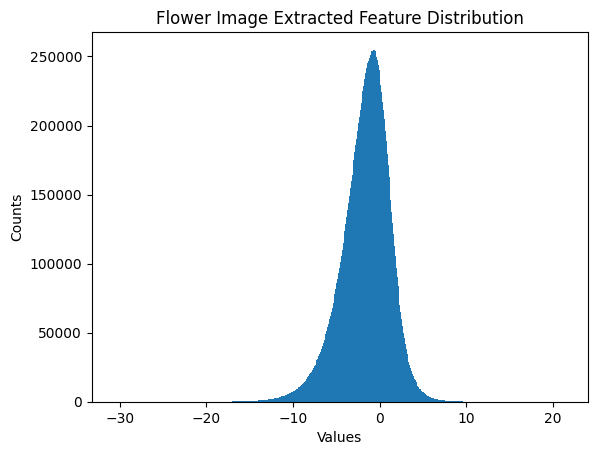

In [190]:
full_train_tf_idf_size = np.prod(full_train_tf_idf.shape)
full_train_tf_idf_non_zero_pct = len(full_train_tf_idf.data)/full_train_tf_idf_size * 100
print(f'TF-IDF Matrix for 20 text classes has {full_train_tf_idf_non_zero_pct:.3f}% non-zero entries')

extracted_features_size = np.prod(f_all.shape)
extracted_features_non_zero_pct = np.count_nonzero(f_all)/extracted_features_size * 100
print(f'Extracted Features Matrix for 5 flower classes has {extracted_features_non_zero_pct:.3f}% non-zero entries')

plt.hist(f_all.flatten(),bins=500)
plt.title('Flower Image Extracted Feature Distribution')
plt.ylabel('Counts')
plt.xlabel('Values')
plt.show()

## Are the extracted features dense or sparse?
As the above shows, the extracted features matrix is much denser than he TF-IDF matrix. More details on how they are distributed can be seen in the histogram.

# Question 23

In [191]:
# Map via TSNE
mapped_features = TSNE().fit_transform(f_all)

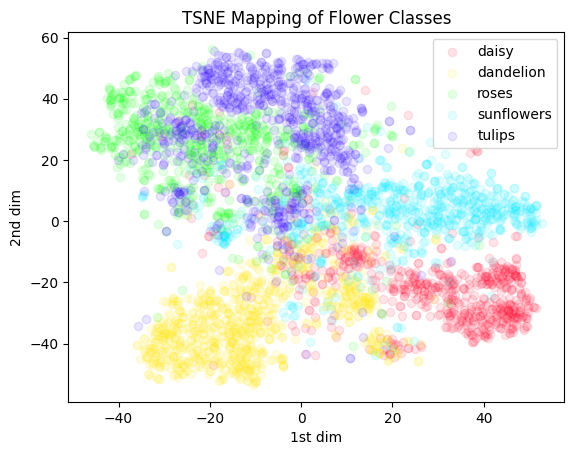

In [192]:
# Plot
class_count = len(np.unique(y_all))
NUM_COLORS = class_count

cm = plt.get_cmap('gist_rainbow')
plt.figure()
ax = plt.gca()
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(0, class_count):
    class_i_indices = np.where(y_all == i)[0]
    ax.scatter(mapped_features[class_i_indices,0],mapped_features[class_i_indices,1], alpha=0.1)

ax.set(xlabel='1st dim', ylabel='2nd dim', title='TSNE Mapping of Flower Classes')
ax.legend(dataset.classes)

## Describe your observation
From the mapping we can observe 5 clusters. The dandelions, daisy and sunflowers ones are  relatively distinct with some overlap at the edges. The roses and tulips on the other hand overlap significantly and cannot be easily separated.

# Question 24

In [193]:
# This is the discussion week 4 helper code copied as is
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in range(100):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [194]:
# Lazy cache that stores all pairings of data + dimensionality reduction
# Works if you have enough RAM
lazy_cache = {}

In [195]:
# Define parameter grid
svd_variants = [TruncatedSVD(n_components=50, random_state=seed)]
autoencoder_variants = [Autoencoder(n_components=50)]
umap_variants = [UMAP(random_state=seed, n_components=50, metric='cosine', n_jobs=8)]
no_dim = [None]

kmeans_variants = [KMeans(n_clusters=5, max_iter=2000, n_init=50, random_state=0)]
agglomerative_variants = [AgglomerativeClustering(n_clusters=5, linkage='ward')]
hdbscan_variants = [hdbscan.HDBSCAN(min_cluster_size=m_c, min_samples=m_s) for m_c in [50, 100, 200, 400] for m_s in [10,20,40,80]]

param_grid = {
    'data_source': [f_all],
    'dim_reduction': svd_variants + autoencoder_variants + umap_variants + no_dim,
    'clustering': kmeans_variants + agglomerative_variants + hdbscan_variants
}
search_configs = []
search_cluster_labels = []

parameter_grid = list(ParameterGrid(param_grid=param_grid))

# Search over possible cases
for g in tqdm(parameter_grid):
    data = g['data_source']

    if g['dim_reduction']:
        cache_str = f"{id(g['data_source'])}-{id(g['dim_reduction'])}"
        if cache_str not in lazy_cache:
            lazy_cache[cache_str] = g['dim_reduction'].fit_transform(data)
        reduced_data = lazy_cache[cache_str]
    else:
        reduced_data = data

    cluster_labels = g['clustering'].fit_predict(reduced_data)
    search_configs.append(g)
    search_cluster_labels.append(cluster_labels)

100%|██████████| 72/72 [24:15<00:00, 20.22s/it]


In [196]:
search_scores = np.array([calculate_cluster_metrics(y_all, c_l) for c_l in search_cluster_labels])
top_5_indices = np.argsort(search_scores[:,3])[-1:]

for i in top_5_indices:
    print()
    print(search_configs[i])
    print_cluster_metrics(*search_scores[i])


{'clustering': KMeans(max_iter=2000, n_clusters=5, n_init=50, random_state=0), 'data_source': array([[-0.84448791, -0.34644449,  0.23280358, ..., -6.90222979,
         0.58245105, -1.01136947],
       [-2.95158625, -2.6339066 , -1.21895576, ..., -6.63238001,
         0.78978968,  4.20510626],
       [-2.53619146,  2.58252454, -0.84017634, ..., -0.82958508,
         2.27429366,  1.42757583],
       ...,
       [-1.80115032, -0.06902575,  1.28768849, ..., -4.72774839,
         0.54368639,  0.94175351],
       [-2.56621289, -2.66626024, -2.93349075, ..., -3.23918939,
         4.09904099,  0.44739348],
       [ 1.16153979, -1.03962457,  2.89491129, ..., -2.67096281,
         1.813627  ,  0.38761479]]), 'dim_reduction': UMAP(angular_rp_forest=True, metric='cosine', n_components=50, n_jobs=8, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})}
Homogeneity Score: 0.531
Completeness Score

As shown above the method yielding the best results is a UMAP dimension reduction + K-Means with an adjusted rand index of 0.466.

# Question 25

In [197]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, dataset: TensorDataset):
        # X = torch.tensor(X, dtype=torch.float32, device='cuda')
        # y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        # dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                y_pred = self.forward(X_)
                loss = criterion(y_pred, y_)
                loss.backward()
                optimizer.step()
        return self

    def eval(self, dataset: TensorDataset):

        self.model.eval()
        y_test = []
        y_preds = []
        # dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        with torch.no_grad():
            for (X_, y_) in dataloader:
                y_preds.append(self.forward(X_))
                y_test.append(y_)

        label_preds = torch.argmax(torch.concat(y_preds), axis=1)
        y_test = torch.concat(y_test)
        return accuracy_score(y_test.cpu(), label_preds.cpu())

In [198]:
def train_and_eval(X: np.ndarray, y:np.ndarray):
    X_t = torch.tensor(X, dtype=torch.float32, device='cuda')
    y_t = torch.tensor(y, dtype=torch.int64, device='cuda')
    entire_dataset = TensorDataset(X_t, y_t)
    train_dataset, test_dataset = random_split(entire_dataset, [int(len(entire_dataset) * 0.8), int(len(entire_dataset) * 0.2)], generator=torch.Generator().manual_seed(seed))
    mlp = MLP(num_features=X_t.shape[1])
    mlp.train(train_dataset)
    accuracy = mlp.eval(test_dataset)
    print(f'Test Accuracy: {accuracy}')

print('\nUsing base features (i.e 4096 dim):')
train_and_eval(f_all, y_all)

print('\nUsing dimensionality reduced features (i.e 50 dim):')
X_reduced = UMAP(random_state=seed, n_components=50, metric='cosine', n_jobs=8).fit_transform(f_all)
train_and_eval(X_reduced, y_all)


Using base features (i.e 4096 dim):


100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


Test Accuracy: 0.9155313351498637

Using dimensionality reduced features (i.e 50 dim):


100%|██████████| 100/100 [00:04<00:00, 22.53it/s]

Test Accuracy: 0.8732970027247956


## Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense?
We can see a decrease in accuracy of -4% from using the full features vs. the dimensionality reduced ones. This is arguably significant especially as the last few percentage points in classification accuracy are usually harder to get than the first few (i.e the hard and noisy examples are usually the most difficult to learn). As for whether this makes sense in the context of the previous dimensionality reduction, it genereally does, as our features are much denser than they were in the TF-IDF case. Reducing these features will result in some loss of information. That said, given the compression from 4096->50 it is still a very good result and we can see in the charts below that UMAP managed to separate the clusters nicely.

In [199]:
# Map via TSNE
mapped_features = TSNE().fit_transform(f_all)
mapped_reduced_features = TSNE().fit_transform(X_reduced)

<Figure size 640x480 with 0 Axes>

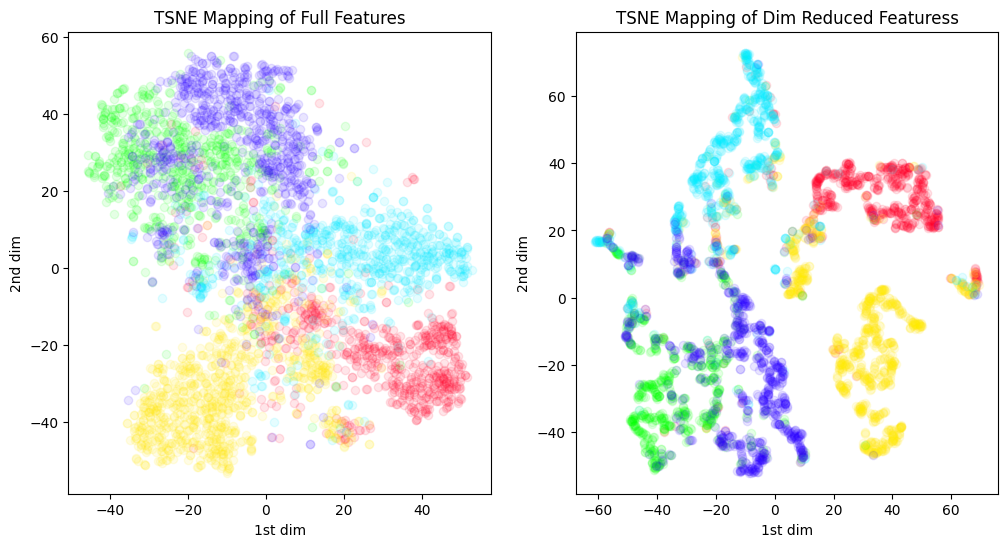

In [200]:
class_count = len(np.unique(y_all))
NUM_COLORS = class_count

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(0, class_count):
    class_i_indices = np.where(y_all == i)[0]
    ax1.scatter(mapped_features[class_i_indices,0],mapped_features[class_i_indices,1], alpha=0.1)

ax1.set(xlabel='1st dim', ylabel='2nd dim', title='TSNE Mapping of Full Features')

ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(0, class_count):
    class_i_indices = np.where(y_all == i)[0]
    ax2.scatter(mapped_reduced_features[class_i_indices,0],mapped_reduced_features[class_i_indices,1], alpha=0.1)

ax2.set(xlabel='1st dim', ylabel='2nd dim', title='TSNE Mapping of Dim Reduced Featuress')
plt.show()